In [1]:
# Standard Imports
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

# Disable truncation of DataFrame display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)
# ...existing code...



##### Data Collection

In [2]:
def get_klines(symbol="BTCUSDT", interval="5m", limit=1000):
    """Fetch OHLCV data from Binance."""
    url = "https://api.binance.com/api/v3/klines"
    params = {"symbol": symbol, "interval": interval, "limit": limit}
    
    raw = requests.get(url, params=params).json()
    
    cols = [
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_volume", "trades", 
        "taker_buy_base", "taker_buy_quote", "ignore"
    ]
    
    df = pd.DataFrame(raw, columns=cols)
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
    
    numeric_cols = ["open", "high", "low", "close", "volume", 
                    "quote_volume", "taker_buy_base", "taker_buy_quote"]
    df[numeric_cols] = df[numeric_cols].astype(float)
    
    return df.drop('ignore', axis=1)


def get_funding_rates(symbol="BTCUSDT", limit=1000):
    """Fetch historical funding rates from Binance Futures."""
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    params = {"symbol": symbol, "limit": limit}
    
    raw = requests.get(url, params=params).json()
    df = pd.DataFrame(raw)
    df["fundingTime"] = pd.to_datetime(df["fundingTime"], unit="ms")
    df["fundingRate"] = df["fundingRate"].astype(float)
    
    return df[["fundingTime", "fundingRate"]]

##### Feature generation - lagged to avoid lookahead bias

In [3]:
# ============================================================================
# CVD FEATURES
# ============================================================================

def calculate_cvd_features(df):
    """Calculate CVD approximation and related features."""
    df = df.copy()
    
    # Basic volume calculations
    df['buy_volume'] = df['taker_buy_base']
    df['sell_volume'] = df['volume'] - df['taker_buy_base']
    df['volume_delta'] = df['buy_volume'] - df['sell_volume']
    df['buy_sell_ratio'] = df['buy_volume'] / df['sell_volume'].replace(0, 1)
    
    # CVD - calculate cumsum first, THEN lag it
    df['cvd'] = df['volume_delta'].cumsum().shift(1)
    
    # Rolling CVD features
    for window in [5, 10, 20]:
        df[f'cvd_slope_{window}'] = df['cvd'].diff(window) / window
        df[f'avg_volume_delta_{window}'] = df['volume_delta'].shift(1).rolling(window).mean()
        df[f'avg_buy_sell_ratio_{window}'] = df['buy_sell_ratio'].shift(1).rolling(window).mean()
    
    return df


# ============================================================================
# TECHNICAL INDICATORS
# ============================================================================

def calculate_technical_features(df):
    """Calculate technical indicators using LAGGED prices."""
    df = df.copy()
    
    # Create lagged OHLCV (use previous bar's data)
    df['open_lag1'] = df['open'].shift(1)
    df['high_lag1'] = df['high'].shift(1)
    df['low_lag1'] = df['low'].shift(1)
    df['close_lag1'] = df['close'].shift(1)
    df['volume_lag1'] = df['volume'].shift(1)
    
    # === Returns (using lagged close) ===
    df['returns'] = df['close_lag1'].pct_change()
    df['log_returns'] = np.log(df['close_lag1'] / df['close_lag1'].shift(1))
    
    # === Volatility (using lagged prices) ===
    # ATR (Average True Range)
    df['high_low'] = df['high_lag1'] - df['low_lag1']
    df['high_close'] = np.abs(df['high_lag1'] - df['close_lag1'].shift(1))
    df['low_close'] = np.abs(df['low_lag1'] - df['close_lag1'].shift(1))
    df['true_range'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)
    df['atr_14'] = df['true_range'].rolling(14).mean()
    df['atr_20'] = df['true_range'].rolling(20).mean()
    
    # Realized volatility
    df['realized_vol_20'] = df['returns'].rolling(20).std()
    
    # Volatility regime (percentile-based)
    df['vol_percentile'] = df['atr_20'].rolling(100).apply(
        lambda x: pd.Series(x).rank(pct=True).iloc[-1] if len(x) > 0 else np.nan
    )
    
    # === Moving Averages (using lagged close) ===
    for period in [10, 20, 50, 100]:
        df[f'sma_{period}'] = df['close_lag1'].rolling(period).mean()
        df[f'ema_{period}'] = df['close_lag1'].ewm(span=period, adjust=False).mean()
    
    # Distance from MAs (using lagged close)
    df['price_to_sma_20'] = df['close_lag1'] / df['sma_20']
    df['price_to_sma_50'] = df['close_lag1'] / df['sma_50']
    
    # === RSI (using lagged close) ===
    delta = df['close_lag1'].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = -delta.where(delta < 0, 0).rolling(14).mean()
    rs = gain / loss
    df['rsi_14'] = 100 - (100 / (1 + rs))
    
    # === MACD (using lagged close) ===
    ema_12 = df['close_lag1'].ewm(span=12, adjust=False).mean()
    ema_26 = df['close_lag1'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_diff'] = df['macd'] - df['macd_signal']
    
    # === ADX (using lagged prices) ===
    high_diff = df['high_lag1'].diff()
    low_diff = -df['low_lag1'].diff()
    
    plus_dm = high_diff.where((high_diff > low_diff) & (high_diff > 0), 0)
    minus_dm = low_diff.where((low_diff > high_diff) & (low_diff > 0), 0)
    
    atr_14 = df['atr_14']
    plus_di = 100 * (plus_dm.ewm(span=14, adjust=False).mean() / atr_14)
    minus_di = 100 * (minus_dm.ewm(span=14, adjust=False).mean() / atr_14)
    
    dx = 100 * np.abs(plus_di - minus_di) / (plus_di + minus_di)
    df['adx_14'] = dx.ewm(span=14, adjust=False).mean()
    df['plus_di'] = plus_di
    df['minus_di'] = minus_di
    
    # === Momentum (using lagged close) ===
    for period in [5, 10, 20]:
        df[f'momentum_{period}'] = df['close_lag1'] - df['close_lag1'].shift(period)
        df[f'roc_{period}'] = df['close_lag1'].pct_change(period) * 100
    
    # === Volume (using lagged volume) ===
    df['volume_ma_20'] = df['volume_lag1'].rolling(20).mean()
    df['volume_ratio'] = df['volume_lag1'] / df['volume_ma_20']
    df['volume_std_20'] = df['volume_lag1'].rolling(20).std()
    
    # Clean up intermediate columns
    df = df.drop(['high_low', 'high_close', 'low_close', 'true_range'], axis=1)
    
    return df


# ============================================================================
# REGIME FEATURES
# ============================================================================

def calculate_regime_features(df):
    """Calculate regime-based features: trend, volatility regime."""
    df = df.copy()
    
    # === Trend Regime (based on SMA relationship) ===
    # 1 = bullish, 0 = neutral, -1 = bearish
    df['trend_regime'] = 0
    df.loc[df['sma_20'] > df['sma_50'], 'trend_regime'] = 1
    df.loc[df['sma_20'] < df['sma_50'], 'trend_regime'] = -1
    
    # === Trend Alignment (multiple timeframes agree) ===
    df['trend_alignment'] = (
        (df['sma_10'] > df['sma_20']) & 
        (df['sma_20'] > df['sma_50']) & 
        (df['close_lag1'] > df['sma_10'])
    ).astype(int)
    
    # === Volatility Regime ===
    # Low/Medium/High based on percentile
    df['volatility_regime'] = pd.cut(
        df['vol_percentile'], 
        bins=[0, 0.33, 0.67, 1.0], 
        labels=['low', 'medium', 'high']
    )
    
    # === Trend Strength Regime (ADX-based) ===
    # Strong trend > 25, weak trend < 20
    df['trend_strength_regime'] = 'ranging'
    df.loc[df['adx_14'] > 25, 'trend_strength_regime'] = 'trending'
    df.loc[df['adx_14'] < 20, 'trend_strength_regime'] = 'weak'
    
    # === Momentum Persistence ===
    # Count consecutive bars with positive returns
    df['positive_returns'] = (df['returns'] > 0).astype(int)
    df['consecutive_up'] = df['positive_returns'].groupby(
        (df['positive_returns'] != df['positive_returns'].shift()).cumsum()
    ).cumsum().shift(1)
    
    # Same for negative
    df['negative_returns'] = (df['returns'] < 0).astype(int)
    df['consecutive_down'] = df['negative_returns'].groupby(
        (df['negative_returns'] != df['negative_returns'].shift()).cumsum()
    ).cumsum().shift(1)
    
    # Clean up
    df = df.drop(['positive_returns', 'negative_returns'], axis=1)
    
    return df


# ============================================================================
# TRIPLE BARRIER LABELING
# ============================================================================

def add_triple_barrier_labels(df, profit_pct=0.015, stop_pct=0.01, time_bars=20):
    """Add triple barrier labels to DataFrame."""
    df = df.copy()
    
    # Initialize columns
    df['label'] = np.nan
    df['barrier_hit'] = None
    df['return'] = np.nan
    df['bars_held'] = np.nan
    
    max_idx = len(df) - time_bars - 1
    
    for i in range(max_idx):
        entry_price = df['close'].iloc[i]
        upper_barrier = entry_price * (1 + profit_pct)
        lower_barrier = entry_price * (1 - stop_pct)
        
        barrier_hit = None
        bars_held = 0
        exit_price = entry_price
        
        for j in range(i + 1, min(i + time_bars + 1, len(df))):
            bars_held = j - i
            
            if df['high'].iloc[j] >= upper_barrier:
                barrier_hit = 'upper'
                exit_price = upper_barrier
                break
            
            if df['low'].iloc[j] <= lower_barrier:
                barrier_hit = 'lower'
                exit_price = lower_barrier
                break
        
        if barrier_hit is None:
            barrier_hit = 'time'
            exit_idx = min(i + time_bars, len(df) - 1)
            exit_price = df['close'].iloc[exit_idx]
            bars_held = exit_idx - i
        
        label = 1 if barrier_hit == 'upper' else (-1 if barrier_hit == 'lower' else 0)
        ret = (exit_price - entry_price) / entry_price
        
        df.iloc[i, df.columns.get_loc('label')] = label
        df.iloc[i, df.columns.get_loc('barrier_hit')] = barrier_hit
        df.iloc[i, df.columns.get_loc('return')] = ret
        df.iloc[i, df.columns.get_loc('bars_held')] = bars_held
    
    df = df.dropna(subset=['label'])
    df['label'] = df['label'].astype(int)
    df['bars_held'] = df['bars_held'].astype(int)
    
    return df


# ============================================================================
# MAIN PIPELINE
# ============================================================================

def create_full_features_dataset(symbol="BTCUSDT", interval="5m", limit=1000,
                                profit_pct=0.015, stop_pct=0.01, time_bars=20,
                                use_csv=False):
    """
    Complete pipeline: fetch data, calculate all features, add labels.
    
    Returns:
        DataFrame with OHLCV, CVD, technical indicators, regimes, and labels.
    """
    if use_csv == False:
        print(f"Fetching {symbol} {interval} data...")
        klines_df = get_klines(symbol, interval, limit)
        
        print("Fetching funding rates...")
        funding_df = get_funding_rates(symbol, limit)

    if use_csv == True:
        print("Loading klines from CSV...")
        klines_df = pd.read_csv(f"{symbol}_{interval}_klines.csv")
        # Convert kline timestamps
        klines_df["open_time"]  = pd.to_datetime(klines_df["open_time"])
        klines_df["close_time"] = pd.to_datetime(klines_df["close_time"])
        
        print("Loading funding rates from CSV...")
        funding_df = pd.read_csv(f"{symbol}_funding_rates.csv")
        # Convert funding timestamp
        funding_df["fundingTime"] = pd.to_datetime(funding_df["fundingTime"])

    print("Calculating CVD features...")
    df = calculate_cvd_features(klines_df)
    
    print("Calculating technical indicators...")
    df = calculate_technical_features(df)
    
    print("Calculating regime features...")
    df = calculate_regime_features(df)
    
    print("Merging funding rates...")
    df = pd.merge_asof(
        df.sort_values("close_time"),
        funding_df.sort_values("fundingTime"),
        left_on="close_time",
        right_on="fundingTime",
        direction="backward"
    )
    
    print("Generating triple barrier labels...")
    df = add_triple_barrier_labels(df, profit_pct, stop_pct, time_bars)
    
    print(f"\nDataset created: {len(df)} rows, {len(df.columns)} columns")
    print(f"\nLabel distribution:")
    print(df['label'].value_counts().sort_index())
    
    return df

In [5]:
# ============================================================================
# EXECUTE FULL DATASET PIPELINE
# ============================================================================

# params
symbol = "BTCUSDT"
interval = "5m"
limit = 1000
profit_pct = 0.005# 0.5% profit target
stop_pct = 0.02# 1% stop loss
time_bars = 20      # interval x time_bars minutes max hold (ie, 5 x  20 = 100 minutes/ 1hour 40minutes)

# Create full dataset
df = create_full_features_dataset(
    symbol=symbol,
    interval=interval,
    limit=limit,
    profit_pct=profit_pct, 
    stop_pct=stop_pct,     
    time_bars=time_bars,
    use_csv=False
)

# Display info
print("\nDataset columns:")
print(df.columns.tolist())


Fetching BTCUSDT 5m data...
Fetching funding rates...
Calculating CVD features...
Calculating technical indicators...
Calculating regime features...
Merging funding rates...
Generating triple barrier labels...

Dataset created: 979 rows, 74 columns

Label distribution:
label
-1      4
 0    549
 1    426
Name: count, dtype: int64

Dataset columns:
['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'trades', 'taker_buy_base', 'taker_buy_quote', 'buy_volume', 'sell_volume', 'volume_delta', 'buy_sell_ratio', 'cvd', 'cvd_slope_5', 'avg_volume_delta_5', 'avg_buy_sell_ratio_5', 'cvd_slope_10', 'avg_volume_delta_10', 'avg_buy_sell_ratio_10', 'cvd_slope_20', 'avg_volume_delta_20', 'avg_buy_sell_ratio_20', 'open_lag1', 'high_lag1', 'low_lag1', 'close_lag1', 'volume_lag1', 'returns', 'log_returns', 'atr_14', 'atr_20', 'realized_vol_20', 'vol_percentile', 'sma_10', 'ema_10', 'sma_20', 'ema_20', 'sma_50', 'ema_50', 'sma_100', 'ema_100', 'price_to_sma_20', 'price_

In [15]:
# df with labels to csv 
# df.to_csv("triple_barrier_with_labels_lagged.csv", index=False)
df = pd.read_csv("triple_barrier_with_labels_lagged.csv")

#### Sample dataset

In [16]:
# Check length of df
print(f"\nFinal dataset length: {len(df)} rows")

# use 20% of data for inital model comparison
df_sample = df.iloc[: int(len(df) * 0.4)]


# Check length of df_sample
print(f"\nFinal dataset length: {len(df_sample)} rows")

# Display first few rows
df_sample.head(3)



Final dataset length: 408636 rows

Final dataset length: 163454 rows


,open_time,open,high,low,close,volume,close_time,quote_volume,trades,taker_buy_base,taker_buy_quote,buy_volume,sell_volume,volume_delta,buy_sell_ratio,cvd,cvd_slope_5,avg_volume_delta_5,avg_buy_sell_ratio_5,cvd_slope_10,avg_volume_delta_10,avg_buy_sell_ratio_10,cvd_slope_20,avg_volume_delta_20,avg_buy_sell_ratio_20,open_lag1,high_lag1,low_lag1,close_lag1,volume_lag1,returns,log_returns,atr_14,atr_20,realized_vol_20,vol_percentile,sma_10,ema_10,sma_20,ema_20,sma_50,ema_50,sma_100,ema_100,price_to_sma_20,price_to_sma_50,rsi_14,macd,macd_signal,macd_diff,adx_14,plus_di,minus_di,momentum_5,roc_5,momentum_10,roc_10,momentum_20,roc_20,volume_ma_20,volume_ratio,volume_std_20,trend_regime,trend_alignment,volatility_regime,trend_strength_regime,consecutive_up,consecutive_down,fundingTime,fundingRate,label,barrier_hit,return,bars_held
0,2022-01-01 00:00:00,46216.93,46391.49,46208.37,46321.34,185.67558,2022-01-01 00:04:59.999,8.598314e+06,4551,106.54655,4.933083e+06,106.54655,79.12903,27.41752,1.346491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,ranging,NaN,NaN,2022-01-01 00:00:00.006,0.0001,0,time,0.009645,20
1,2022-01-01 00:05:00,46321.34,46527.26,46280.00,46371.11,123.43577,2022-01-01 00:09:59.999,5.730875e+06,3937,61.10408,2.836664e+06,61.10408,62.33169,-1.22761,0.980305,27.41752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46216.93,46391.49,46208.37,46321.34,185.67558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46321.340000,NaN,46321.34,NaN,46321.340000,NaN,46321.340000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,ranging,0.0,0.0,2022-01-01 00:00:00.006,0.0001,0,time,0.008639,20
2,2022-01-01 00:10:00,46369.79,46394.00,46276.22,46332.51,77.54574,2022-01-01 00:14:59.999,3.592816e+06,2616,42.93039,1.988818e+06,42.93039,34.61535,8.31504,1.240213,26.18991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46321.34,46527.26,46280.00,46371.11,123.43577,0.001074,0.001074,NaN,NaN,NaN,NaN,NaN,46330.389091,NaN,46326.08,NaN,46323.291765,NaN,46322.325545,NaN,NaN,NaN,3.970256,0.794051,3.176205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,ranging,0.0,0.0,2022-01-01 00:00:00.006,0.0001,0,time,0.010503,20


In [6]:
df_sample = df.copy()

Text(0.5, 1.0, 'Label Distribution')

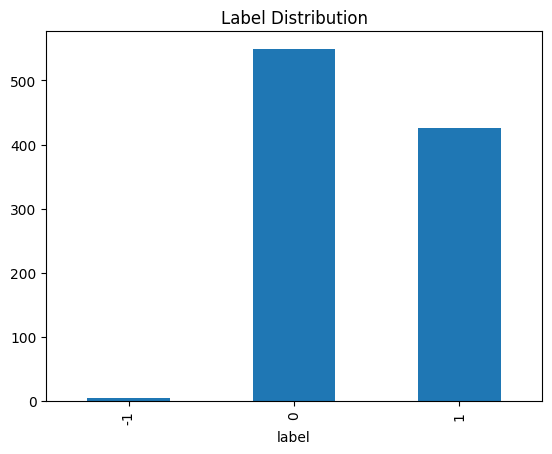

In [7]:
# visulize label distribution
df_sample['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Label Distribution')

##### Preprocessing

In [8]:
# Copy dataframe to avoid affecting original
df_copy = df_sample.copy()

# Expect NaN values due to rolling calculations - largest missing based on longest rolling window
# drop rows with NaN values
df_copy = df_copy.dropna().reset_index(drop=True)

# further sample of dataframe to reduce size for modeling
sample_df = df_copy[['cvd', 'cvd_slope_5', 'cvd_slope_10',
                  'avg_buy_sell_ratio_5', 'avg_buy_sell_ratio_10',
                  'atr_14', 'adx_14', 'momentum_10', 'roc_10',
                    'trend_regime',
                    'trend_alignment', 'consecutive_up',
                    'consecutive_down', 'label', 'close_lag1','ema_10','sma_50']]

# may need to lag funding rate

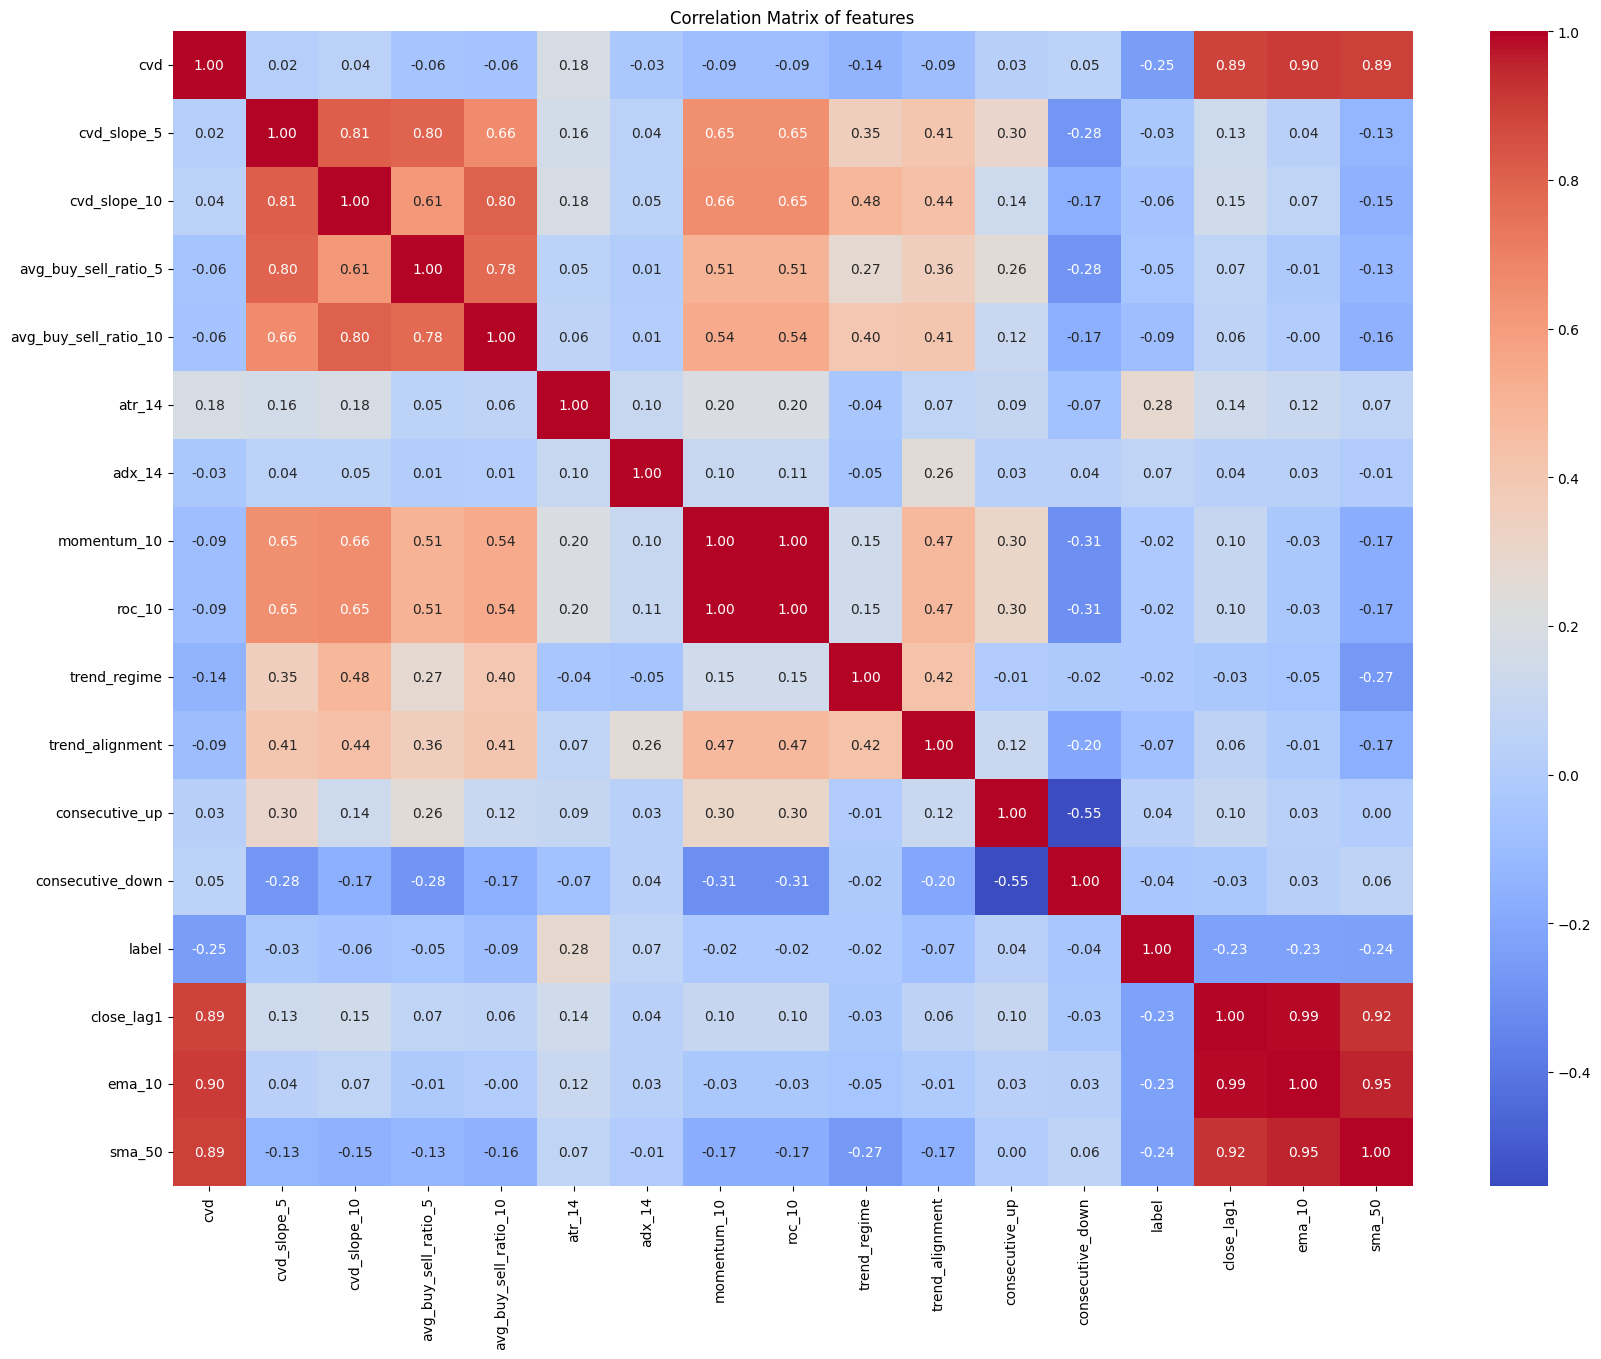

In [9]:
# correlation matrix 
corr_matrix = sample_df.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of features")
plt.show()

##### Train test splits

In [10]:
# Separate features into X and y variables
X = sample_df.drop(['label'], axis=1)
y = sample_df['label']

# For time series: simple chronological split, NO shuffling
split_idx = int(len(sample_df) * 0.8)
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

# check to confirm that X_train and y_train have same datetime index
print(X_train.index.equals(y_train.index))
print(X_test.index.equals(y_test.index))

True
True


##### Feature Scaling 

In [11]:
features_to_scale = [
    'cvd',                    # Large negative values, wide range
    'cvd_slope_5',            # Can be large positive/negative
    'cvd_slope_10',           # Can be large positive/negative
    'atr_14',                 # Absolute price values, needs scaling
    'momentum_10',            # Large range (-2211 to 3209)          # Large absolute values
    'consecutive_up',         # Counts can grow
    'consecutive_down',       # Counts can grow
    'ema_10',                 # Price based, large values
    'sma_50',                  # Price based, large values
    'close_lag1'                # Price based, large values
]

# Features already bounded or meaningful without scaling
features_no_scale = [
    'avg_buy_sell_ratio_5',   # Ratios are already meaningful
    'avg_buy_sell_ratio_10',  # Ratios are already meaningful
    'adx_14',                 # Bounded 0-100
    'roc_10',                 # Rate of change, already % based, small range
    'trend_regime',           # Categorical (-1, 0, 1)
    'trend_alignment'       # Binary (0, 1)
                # Already small decimals (0.00001 range)
]

# removed fundingRate (needs to be lagged)

from sklearn.preprocessing import RobustScaler, LabelEncoder

# initialize scaler
scaler = RobustScaler()

# Fit_transform ONLY on training data for columns that need scaling - transform test data
X_train_scaled = X_train.copy()
X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])


In [12]:
# XGBoost and LightGBM require labels to be 0-indexed - use LabelEncoder which handles this
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [13]:
X_train_scaled.describe()

,cvd,cvd_slope_5,cvd_slope_10,avg_buy_sell_ratio_5,avg_buy_sell_ratio_10,atr_14,adx_14,momentum_10,roc_10,trend_regime,trend_alignment,consecutive_up,consecutive_down,close_lag1,ema_10,sma_50
count,688.000000,688.000000,688.000000,688.000000,688.000000,6.880000e+02,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,6.880000e+02,688.000000,6.880000e+02
mean,0.082603,-0.000550,0.003678,1.205089,1.207768,1.450973e-01,33.244964,-0.009407,0.064664,0.372093,0.254360,-0.023256,0.902616,-1.972088e-02,-0.034603,-5.429511e-02
std,0.651842,1.045959,0.930504,0.353488,0.272020,9.367389e-01,13.061827,0.800364,0.467223,0.928871,0.435818,1.308147,1.206771,8.738933e-01,0.961741,1.040420e+00
min,-1.138252,-4.195827,-2.971576,0.460704,0.552666,-1.472273e+00,11.552956,-2.424633,-1.327303,-1.000000,0.000000,-1.000000,0.000000,-1.810899e+00,-1.864429,-2.145327e+00
25%,-0.278540,-0.501729,-0.503294,0.947028,1.025693,-4.557902e-01,23.547995,-0.522025,-0.236902,-1.000000,0.000000,-1.000000,0.000000,-4.504535e-01,-0.470377,-3.758697e-01
50%,0.000000,0.000000,0.000000,1.192785,1.196643,-2.461817e-16,30.765494,0.000000,0.069028,1.000000,0.000000,0.000000,0.000000,5.309121e-15,0.000000,-6.540775e-15
75%,0.721460,0.498271,0.496706,1.419244,1.392152,5.442098e-01,39.836095,0.477975,0.345528,1.000000,1.000000,0.000000,1.000000,5.495465e-01,0.529623,6.241303e-01
max,1.228216,3.846242,3.091655,2.423468,2.213911,4.876617e+00,84.460900,2.594514,1.585623,1.000000,1.000000,6.000000,7.000000,1.945220e+00,1.976684,2.111966e+00


##### Compare performance of multiple models witg cross-val

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier, ExtraTreesClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, log_loss)
import time

In [15]:
# ============================================================================
# DEFINE MODELS (Using Defaults with Minimal Configuration)
# ============================================================================

models = {
    # Linear Models
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        class_weight='balanced',
        max_iter=1000  # Only to ensure convergence
    ),
    
    'Logistic (L1)': LogisticRegression(
        penalty='l1',
        solver='saga',
        random_state=42,
        class_weight='balanced',
        max_iter=1000
    ),
    
    # Naive Bayes
    'Naive Bayes': GaussianNB(),

    
    # Nearest Neighbors (test different k values but keep other defaults)
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    # 'KNN (k=10)': KNeighborsClassifier(n_neighbors=10),
    
    # SVM
    # 'SVM (Linear)': SVC(
    #     kernel='linear',
    #     probability=True,
    #     random_state=42,
    #     class_weight='balanced'
    # ),
    
    # Tree-based Models (defaults only)
    'Decision Tree': DecisionTreeClassifier(
        random_state=42,
        class_weight='balanced'
    ),
    
    'Random Forest': RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    
    'Extra Trees': ExtraTreesClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    
    # Boosting Models (defaults only)
    'AdaBoost': AdaBoostClassifier(
        random_state=42,
        algorithm='SAMME'
    ),
    
    'Gradient Boosting': GradientBoostingClassifier(
        random_state=42
    ),
    
    'XGBoost': XGBClassifier(
        random_state=42,
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    
    'LightGBM': LGBMClassifier(
        random_state=42,
        class_weight='balanced',
        verbose=-1
    ),
}

In [16]:
# ============================================================================
# TRAIN AND EVALUATE ALL MODELS - NO CV
# ============================================================================

results = []

print("\n" + "="*80)
print("TRAINING MODELS")
print("="*80)

for model_name, model in models.items():
    print(f"\n{'─'*80}")
    print(f"Training: {model_name}")
    print(f"{'─'*80}")
    
    try:
        # Determine which labels to use (encoded for XGBoost/LightGBM)
        if model_name in ['XGBoost', 'LightGBM']:
            y_train_use = y_train_encoded
            y_test_use = y_test_encoded
        else:
            y_train_use = y_train
            y_test_use = y_test
        
        # Time training
        start_time = time.time()
        model.fit(X_train_scaled, y_train_use)
        train_time = time.time() - start_time
        
        # Predictions
        start_time = time.time()
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
        predict_time = time.time() - start_time
        
        # Decode predictions if needed (convert back to original labels)
        if model_name in ['XGBoost', 'LightGBM']:
            y_train_pred = label_encoder.inverse_transform(y_train_pred)
            y_test_pred = label_encoder.inverse_transform(y_test_pred)
        
        # Probabilities (if available)
        try:
            y_test_pred_proba = model.predict_proba(X_test_scaled)
            has_proba = True
        except:
            y_test_pred_proba = None
            has_proba = False
        
        # Calculate metrics (always use original labels for consistency)
        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc = accuracy_score(y_test, y_test_pred)
        
        val_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
        val_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
        val_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
        
        # Per-class accuracy
        class_accuracies = {}
        for label in [-1, 0, 1]:
            mask = y_test == label
            if mask.sum() > 0:
                class_acc = accuracy_score(y_test[mask], y_test_pred[mask])
                class_accuracies[label] = class_acc
            else:
                class_accuracies[label] = np.nan
        
        # ROC AUC (if probabilities available)
        if has_proba:
            try:
                val_auc = roc_auc_score(y_test, y_test_pred_proba, 
                                       multi_class='ovr', average='weighted')
                val_logloss = log_loss(y_test, y_test_pred_proba)
            except:
                val_auc = np.nan
                val_logloss = np.nan
        else:
            val_auc = np.nan
            val_logloss = np.nan
        
        # Store results
        results.append({
            'Model': model_name,
            'Train_Accuracy': train_acc,
            'Val_Accuracy': val_acc,
            'Val_Precision': val_precision,
            'Val_Recall': val_recall,
            'Val_F1': val_f1,
            'Val_AUC': val_auc,
            'Val_LogLoss': val_logloss,
            'Loss_Accuracy': class_accuracies.get(-1, np.nan),
            'Time_Accuracy': class_accuracies.get(0, np.nan),
            'Profit_Accuracy': class_accuracies.get(1, np.nan),
            'Overfit_Gap': train_acc - val_acc,
            'Train_Time': train_time,
            'Predict_Time': predict_time,
            'Has_Proba': has_proba
        })
        
        print(f"✓ Training Accuracy:   {train_acc:.4f}")
        print(f"✓ Validation Accuracy: {val_acc:.4f}")
        print(f"✓ F1 Score:            {val_f1:.4f}")
        print(f"✓ Train Time:          {train_time:.2f}s")
        
    except Exception as e:
        print(f"✗ Error: {str(e)}")
        results.append({
            'Model': model_name,
            'Train_Accuracy': np.nan,
            'Val_Accuracy': np.nan,
            'Val_Precision': np.nan,
            'Val_Recall': np.nan,
            'Val_F1': np.nan,
            'Val_AUC': np.nan,
            'Val_LogLoss': np.nan,
            'Loss_Accuracy': np.nan,
            'Time_Accuracy': np.nan,
            'Profit_Accuracy': np.nan,
            'Overfit_Gap': np.nan,
            'Train_Time': np.nan,
            'Predict_Time': np.nan,
            'Has_Proba': False
        })


TRAINING MODELS

────────────────────────────────────────────────────────────────────────────────
Training: Logistic Regression
────────────────────────────────────────────────────────────────────────────────
✓ Training Accuracy:   0.6991
✓ Validation Accuracy: 0.5000
✓ F1 Score:            0.5466
✓ Train Time:          0.13s

────────────────────────────────────────────────────────────────────────────────
Training: Logistic (L1)
────────────────────────────────────────────────────────────────────────────────


c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✓ Training Accuracy:   0.6802
✓ Validation Accuracy: 0.5988
✓ F1 Score:            0.6325
✓ Train Time:          0.37s

────────────────────────────────────────────────────────────────────────────────
Training: Naive Bayes
────────────────────────────────────────────────────────────────────────────────
✓ Training Accuracy:   0.6497
✓ Validation Accuracy: 0.7151
✓ F1 Score:            0.6950
✓ Train Time:          0.00s

────────────────────────────────────────────────────────────────────────────────
Training: KNN (k=5)
────────────────────────────────────────────────────────────────────────────────
✓ Training Accuracy:   0.7922
✓ Validation Accuracy: 0.5756
✓ F1 Score:            0.6101
✓ Train Time:          0.00s

────────────────────────────────────────────────────────────────────────────────
Training: Decision Tree
────────────────────────────────────────────────────────────────────────────────
✓ Training Accuracy:   1.0000
✓ Validation Accuracy: 0.5640
✓ F1 Score:            0.574

c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


✓ Training Accuracy:   0.9884
✓ Validation Accuracy: 0.6802
✓ F1 Score:            0.6786
✓ Train Time:          0.93s

────────────────────────────────────────────────────────────────────────────────
Training: XGBoost
────────────────────────────────────────────────────────────────────────────────


c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:28:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✓ Training Accuracy:   1.0000
✓ Validation Accuracy: 0.6860
✓ F1 Score:            0.7012
✓ Train Time:          1.65s

────────────────────────────────────────────────────────────────────────────────
Training: LightGBM
────────────────────────────────────────────────────────────────────────────────
✓ Training Accuracy:   1.0000
✓ Validation Accuracy: 0.6977
✓ F1 Score:            0.7059
✓ Train Time:          0.14s


In [17]:
results_df = pd.DataFrame(results)
results_df

,Model,Train_Accuracy,Val_Accuracy,Val_Precision,Val_Recall,Val_F1,Val_AUC,Val_LogLoss,Loss_Accuracy,Time_Accuracy,Profit_Accuracy,Overfit_Gap,Train_Time,Predict_Time,Has_Proba
0,Logistic Regression,0.699128,0.500000,0.655827,0.500000,0.546573,NaN,NaN,NaN,0.514706,0.444444,0.199128,0.133594,0.012250,True
1,Logistic (L1),0.680233,0.598837,0.694424,0.598837,0.632492,NaN,NaN,NaN,0.639706,0.444444,0.081395,0.368185,0.000000,True
2,Naive Bayes,0.649709,0.715116,0.679563,0.715116,0.694967,NaN,NaN,NaN,0.860294,0.166667,-0.065407,0.002207,0.002008,True
3,KNN (k=5),0.792151,0.575581,0.667043,0.575581,0.610070,NaN,NaN,NaN,0.632353,0.361111,0.216570,0.000000,3.067983,True
4,Decision Tree,1.000000,0.563953,0.584548,0.563953,0.574028,NaN,NaN,NaN,0.705882,0.027778,0.436047,0.021649,0.001994,True
5,Random Forest,1.000000,0.732558,0.703458,0.732558,0.715732,NaN,NaN,NaN,0.867647,0.222222,0.267442,0.159337,0.057671,True
6,Extra Trees,1.000000,0.720930,0.720930,0.720930,0.720930,NaN,NaN,NaN,0.823529,0.333333,0.279070,0.111430,0.065107,True
7,AdaBoost,0.497093,0.790698,0.625203,0.790698,0.698278,NaN,NaN,NaN,1.000000,0.000000,-0.293605,0.124748,0.016297,True
8,Gradient Boosting,0.988372,0.680233,0.676936,0.680233,0.678566,NaN,NaN,NaN,0.801471,0.222222,0.308140,0.933924,0.003990,True
9,XGBoost,1.000000,0.686047,0.722196,0.686047,0.701227,NaN,NaN,NaN,0.757353,0.416667,0.313953,1.647106,0.012824,True


##### Model Comparison with Cross Validation


CROSS-VALIDATION MODEL COMPARISON

Using 5-fold Time Series Cross-Validation
Training set size: 688

────────────────────────────────────────────────────────────────────────────────
CV Training: Logistic Regression
────────────────────────────────────────────────────────────────────────────────
  Fold 1: Train=98, Val=114, Gap=21 bars
  Fold 2: Train=212, Val=114, Gap=21 bars
  Fold 3: Train=326, Val=114, Gap=21 bars
  Fold 4: Train=440, Val=114, Gap=21 bars
  Fold 5: Train=554, Val=114, Gap=21 bars


C:\Users\User\AppData\Local\Temp\ipykernel_11288\3358890599.py:167: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✓ CV Accuracy: 0.5491 (±0.0428)
✓ CV F1:       0.5283
✓ Total Time:  0.24s

────────────────────────────────────────────────────────────────────────────────
CV Training: Logistic (L1)
────────────────────────────────────────────────────────────────────────────────
  Fold 1: Train=98, Val=114, Gap=21 bars
  Fold 2: Train=212, Val=114, Gap=21 bars
  Fold 3: Train=326, Val=114, Gap=21 bars
  Fold 4: Train=440, Val=114, Gap=21 bars


c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Fold 5: Train=554, Val=114, Gap=21 bars


c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_11288\3358890599.py:167: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,
C:\Users\User\AppData\Local\Temp\ipykernel_11288\3358890599.py:167: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,


✓ CV Accuracy: 0.5140 (±0.0634)
✓ CV F1:       0.4751
✓ Total Time:  0.52s

────────────────────────────────────────────────────────────────────────────────
CV Training: Naive Bayes
────────────────────────────────────────────────────────────────────────────────
  Fold 1: Train=98, Val=114, Gap=21 bars
  Fold 2: Train=212, Val=114, Gap=21 bars
  Fold 3: Train=326, Val=114, Gap=21 bars
  Fold 4: Train=440, Val=114, Gap=21 bars
  Fold 5: Train=554, Val=114, Gap=21 bars
✓ CV Accuracy: 0.4368 (±0.1181)
✓ CV F1:       0.3647
✓ Total Time:  0.01s

────────────────────────────────────────────────────────────────────────────────
CV Training: KNN (k=5)
────────────────────────────────────────────────────────────────────────────────
  Fold 1: Train=98, Val=114, Gap=21 bars
  Fold 2: Train=212, Val=114, Gap=21 bars
  Fold 3: Train=326, Val=114, Gap=21 bars
  Fold 4: Train=440, Val=114, Gap=21 bars
  Fold 5: Train=554, Val=114, Gap=21 bars
✓ CV Accuracy: 0.4772 (±0.0463)
✓ CV F1:       0.4596
✓ To

C:\Users\User\AppData\Local\Temp\ipykernel_11288\3358890599.py:167: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,
C:\Users\User\AppData\Local\Temp\ipykernel_11288\3358890599.py:167: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,


  Fold 2: Train=212, Val=114, Gap=21 bars
  Fold 3: Train=326, Val=114, Gap=21 bars
  Fold 4: Train=440, Val=114, Gap=21 bars
  Fold 5: Train=554, Val=114, Gap=21 bars


C:\Users\User\AppData\Local\Temp\ipykernel_11288\3358890599.py:167: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,


✓ CV Accuracy: 0.5000 (±0.1054)
✓ CV F1:       0.4204
✓ Total Time:  0.70s

────────────────────────────────────────────────────────────────────────────────
CV Training: Extra Trees
────────────────────────────────────────────────────────────────────────────────
  Fold 1: Train=98, Val=114, Gap=21 bars
  Fold 2: Train=212, Val=114, Gap=21 bars
  Fold 3: Train=326, Val=114, Gap=21 bars
  Fold 4: Train=440, Val=114, Gap=21 bars
  Fold 5: Train=554, Val=114, Gap=21 bars


C:\Users\User\AppData\Local\Temp\ipykernel_11288\3358890599.py:167: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


✓ CV Accuracy: 0.4825 (±0.1126)
✓ CV F1:       0.4023
✓ Total Time:  0.56s

────────────────────────────────────────────────────────────────────────────────
CV Training: AdaBoost
────────────────────────────────────────────────────────────────────────────────
  Fold 1: Train=98, Val=114, Gap=21 bars
  Fold 2: Train=212, Val=114, Gap=21 bars
  Fold 3: Train=326, Val=114, Gap=21 bars
  Fold 4: Train=440, Val=114, Gap=21 bars
  Fold 5: Train=554, Val=114, Gap=21 bars
✓ CV Accuracy: 0.5333 (±0.0572)
✓ CV F1:       0.4462
✓ Total Time:  0.34s

────────────────────────────────────────────────────────────────────────────────
CV Training: Gradient Boosting
────────────────────────────────────────────────────────────────────────────────
  Fold 1: Train=98, Val=114, Gap=21 bars


c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_11288\3358890599.py:167: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,


  Fold 2: Train=212, Val=114, Gap=21 bars
  Fold 3: Train=326, Val=114, Gap=21 bars
  Fold 4: Train=440, Val=114, Gap=21 bars
  Fold 5: Train=554, Val=114, Gap=21 bars


C:\Users\User\AppData\Local\Temp\ipykernel_11288\3358890599.py:167: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,


✓ CV Accuracy: 0.5491 (±0.0636)
✓ CV F1:       0.5201
✓ Total Time:  1.67s

────────────────────────────────────────────────────────────────────────────────
CV Training: XGBoost
────────────────────────────────────────────────────────────────────────────────
  Fold 1: Train=98, Val=114, Gap=21 bars
✗ Error: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got [1 2]

────────────────────────────────────────────────────────────────────────────────
CV Training: LightGBM
────────────────────────────────────────────────────────────────────────────────
  Fold 1: Train=98, Val=114, Gap=21 bars
  Fold 2: Train=212, Val=114, Gap=21 bars
  Fold 3: Train=326, Val=114, Gap=21 bars
  Fold 4: Train=440, Val=114, Gap=21 bars
  Fold 5: Train=554, Val=114, Gap=21 bars


C:\Users\User\AppData\Local\Temp\ipykernel_11288\3358890599.py:167: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,
C:\Users\User\AppData\Local\Temp\ipykernel_11288\3358890599.py:342: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(fold_data, labels=fold_labels, patch_artist=True)


✓ CV Accuracy: 0.5228 (±0.0971)
✓ CV F1:       0.4647
✓ Total Time:  0.22s

CROSS-VALIDATION RESULTS

📊 Overall CV Performance (sorted by Mean Accuracy):
              Model  CV_Accuracy_Mean  CV_Accuracy_Std  CV_F1_Mean  CV_Precision_Mean  CV_Recall_Mean
Logistic Regression          0.549123         0.042830    0.528256           0.595301        0.549123
      Decision Tree          0.549123         0.076190    0.530227           0.659482        0.549123
  Gradient Boosting          0.549123         0.063643    0.520105           0.658640        0.549123
           AdaBoost          0.533333         0.057226    0.446172           0.497821        0.533333
           LightGBM          0.522807         0.097143    0.464666           0.641038        0.522807
      Logistic (L1)          0.514035         0.063401    0.475074           0.600729        0.514035
      Random Forest          0.500000         0.105409    0.420362           0.650283        0.500000
        Extra Trees          0

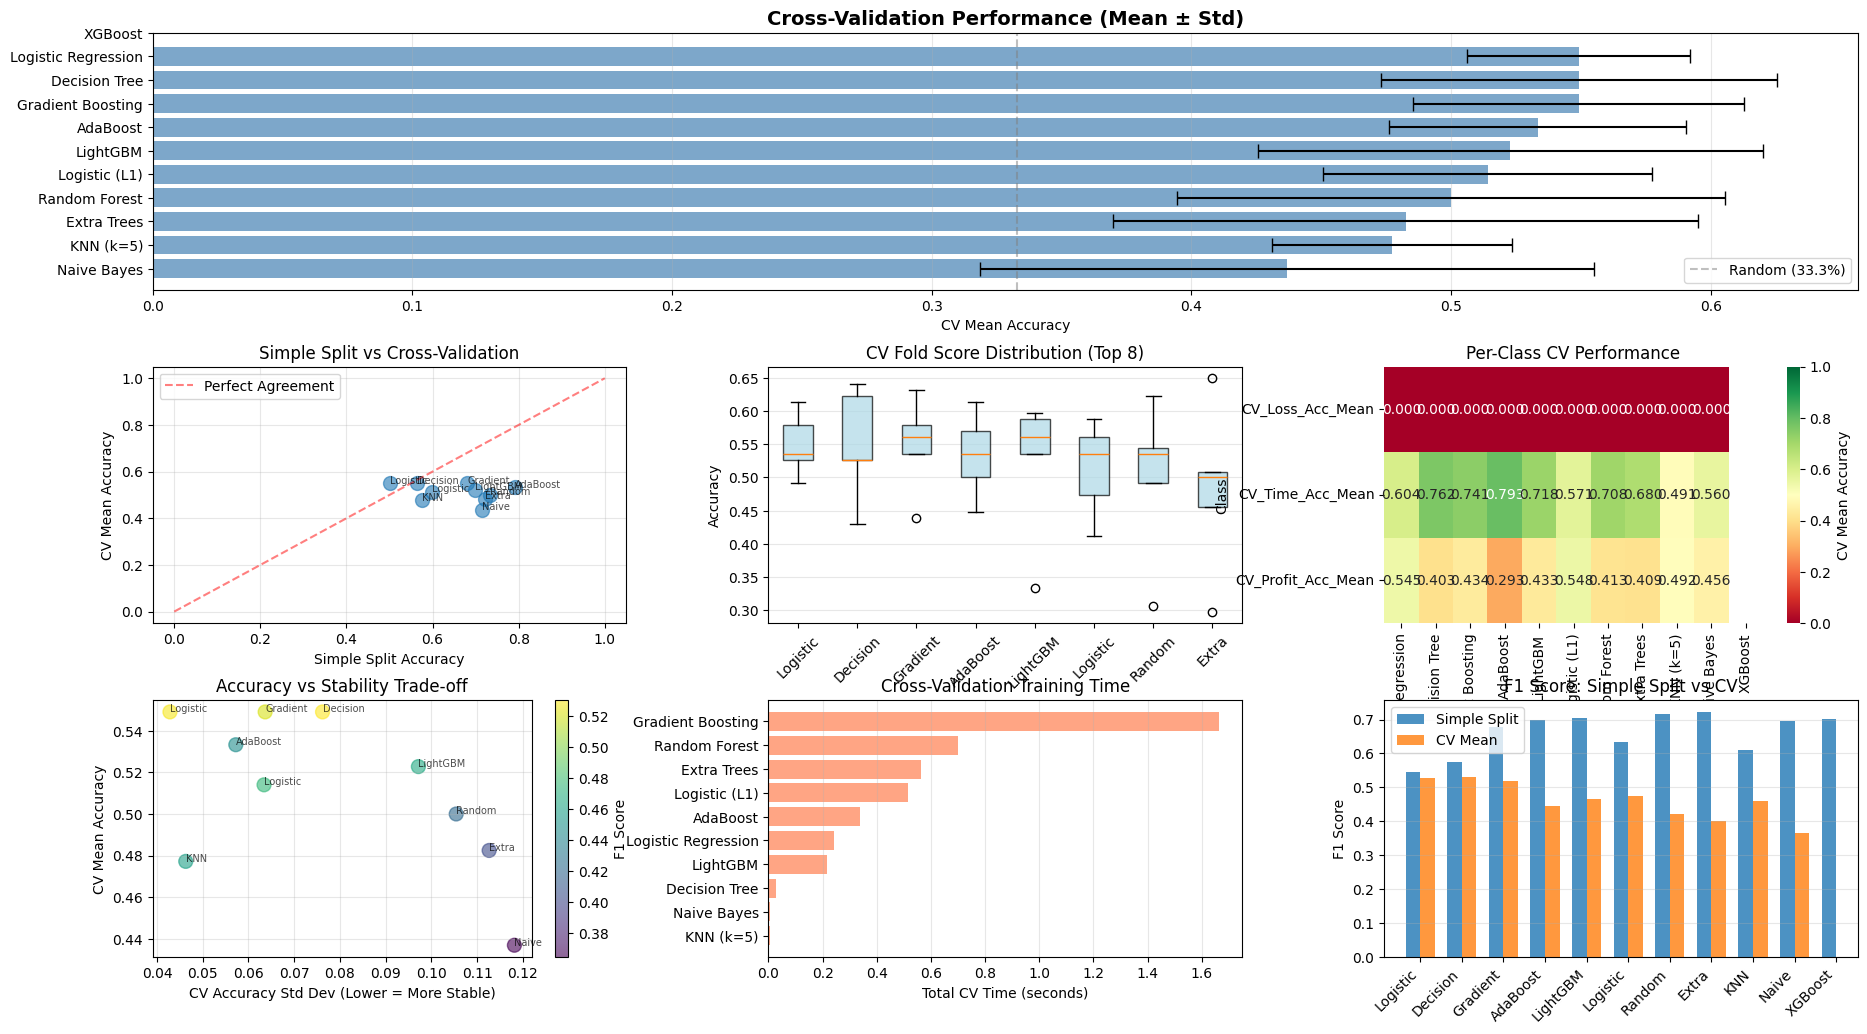


✓ CV results saved to 'cv_model_comparison_results.csv'
✓ Comparison saved to 'simple_vs_cv_comparison.csv'


In [18]:
# ============================================================================
# EMBARGO FUNCTION FOR CROSS-VALIDATION
# ============================================================================

def purge_embargo_cv(train_idx, val_idx, embargo_bars=20):
    """
    Remove training samples that overlap with test period.
    
    This prevents label leakage in cross-validation where training labels
    might use future prices that overlap with the test set.
    
    Parameters:
    -----------
    train_idx : array
        Training indices from TimeSeriesSplit
    val_idx : array
        Validation indices from TimeSeriesSplit
    embargo_bars : int
        Number of bars to embargo (should match time_bars in triple barrier)
    
    Returns:
    --------
    train_idx, val_idx : tuple
        Purged indices with embargo applied
    """
    if len(val_idx) == 0:
        return train_idx, val_idx
    
    test_start = val_idx[0]
    # Remove training samples within embargo period of test start
    train_idx = train_idx[train_idx < test_start - embargo_bars]
    
    return train_idx, val_idx


# ============================================================================
# CROSS-VALIDATION MODEL COMPARISON
# ============================================================================

from sklearn.model_selection import TimeSeriesSplit

print("\n" + "="*80)
print("CROSS-VALIDATION MODEL COMPARISON")
print("="*80)

# Use TimeSeriesSplit for time series data (respects temporal order)
tscv = TimeSeriesSplit(n_splits=5)

cv_results = []

print("\nUsing 5-fold Time Series Cross-Validation")
print(f"Training set size: {len(X_train_scaled)}")

for model_name, model in models.items():
    print(f"\n{'─'*80}")
    print(f"CV Training: {model_name}")
    print(f"{'─'*80}")
    
    fold_scores = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': [],
        'loss_acc': [],
        'time_acc': [],
        'profit_acc': []
    }
    fold_times = []
    
    try:
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
            # Apply embargo to prevent leakage
            train_idx, val_idx = purge_embargo_cv(train_idx, val_idx, embargo_bars=time_bars)

            # Diagnostic: print fold sizes
            train_end = train_idx[-1] if len(train_idx) > 0 else 0
            val_start = val_idx[0] if len(val_idx) > 0 else 0
            gap = val_start - train_end
            print(f"  Fold {fold+1}: Train={len(train_idx)}, Val={len(val_idx)}, Gap={gap} bars")

            # Split fold data
            X_fold_train = X_train.iloc[train_idx].copy()
            X_fold_val = X_train.iloc[val_idx].copy()
            
            # Get labels (encoded or original depending on model)
            if model_name in ['XGBoost', 'LightGBM']:
                y_fold_train = y_train_encoded[train_idx]
                y_fold_val = y_train_encoded[val_idx]
                y_fold_val_original = y_train.iloc[val_idx]
            else:
                y_fold_train = y_train.iloc[train_idx]
                y_fold_val = y_train.iloc[val_idx]
                y_fold_val_original = y_fold_val
            
            # Fit scaler on this fold's training data
            fold_scaler = RobustScaler()
            X_fold_train_scaled = X_fold_train.copy()
            X_fold_train_scaled[features_to_scale] = fold_scaler.fit_transform(
                X_fold_train[features_to_scale]
            )
            
            X_fold_val_scaled = X_fold_val.copy()
            X_fold_val_scaled[features_to_scale] = fold_scaler.transform(
                X_fold_val[features_to_scale]
            )
            
            # Train model on this fold
            fold_start = time.time()
            
            # Clone model to avoid fitting same instance
            from sklearn.base import clone
            fold_model = clone(model)
            fold_model.fit(X_fold_train_scaled, y_fold_train)
            
            fold_time = time.time() - fold_start
            fold_times.append(fold_time)
            
            # Predict
            y_fold_pred = fold_model.predict(X_fold_val_scaled)
            
            # Decode predictions if needed
            if model_name in ['XGBoost', 'LightGBM']:
                y_fold_pred = label_encoder.inverse_transform(y_fold_pred)
            
            # Calculate metrics
            fold_acc = accuracy_score(y_fold_val_original, y_fold_pred)
            fold_precision = precision_score(y_fold_val_original, y_fold_pred, 
                                            average='weighted', zero_division=0)
            fold_recall = recall_score(y_fold_val_original, y_fold_pred, 
                                       average='weighted', zero_division=0)
            fold_f1 = f1_score(y_fold_val_original, y_fold_pred, 
                              average='weighted', zero_division=0)
            
            # Store scores
            fold_scores['accuracy'].append(fold_acc)
            fold_scores['precision'].append(fold_precision)
            fold_scores['recall'].append(fold_recall)
            fold_scores['f1'].append(fold_f1)
            
            # Per-class accuracy
            for label, key in [(-1, 'loss_acc'), (0, 'time_acc'), (1, 'profit_acc')]:
                mask = y_fold_val_original == label
                if mask.sum() > 0:
                    class_acc = accuracy_score(y_fold_val_original[mask], y_fold_pred[mask])
                    fold_scores[key].append(class_acc)
                else:
                    fold_scores[key].append(np.nan)
            
            # AUC (if probabilities available)
            try:
                y_fold_proba = fold_model.predict_proba(X_fold_val_scaled)
                fold_auc = roc_auc_score(y_fold_val_original, y_fold_proba, 
                                        multi_class='ovr', average='weighted')
                fold_scores['auc'].append(fold_auc)
            except:
                fold_scores['auc'].append(np.nan)
        
        # Calculate mean and std across folds
        cv_results.append({
            'Model': model_name,
            'CV_Accuracy_Mean': np.mean(fold_scores['accuracy']),
            'CV_Accuracy_Std': np.std(fold_scores['accuracy']),
            'CV_Precision_Mean': np.mean(fold_scores['precision']),
            'CV_Recall_Mean': np.mean(fold_scores['recall']),
            'CV_F1_Mean': np.mean(fold_scores['f1']),
            'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,
            'CV_Loss_Acc_Mean': np.nanmean(fold_scores['loss_acc']),
            'CV_Time_Acc_Mean': np.nanmean(fold_scores['time_acc']),
            'CV_Profit_Acc_Mean': np.nanmean(fold_scores['profit_acc']),
            'CV_Loss_Acc_Std': np.nanstd(fold_scores['loss_acc']),
            'CV_Time_Acc_Std': np.nanstd(fold_scores['time_acc']),
            'CV_Profit_Acc_Std': np.nanstd(fold_scores['profit_acc']),
            'CV_Avg_Fold_Time': np.mean(fold_times),
            'CV_Total_Time': np.sum(fold_times),
            'Fold_Scores': fold_scores['accuracy']  # Store individual fold scores
        })
        
        print(f"✓ CV Accuracy: {np.mean(fold_scores['accuracy']):.4f} (±{np.std(fold_scores['accuracy']):.4f})")
        print(f"✓ CV F1:       {np.mean(fold_scores['f1']):.4f}")
        print(f"✓ Total Time:  {np.sum(fold_times):.2f}s")
        
    except Exception as e:
        print(f"✗ Error: {str(e)}")
        cv_results.append({
            'Model': model_name,
            'CV_Accuracy_Mean': np.nan,
            'CV_Accuracy_Std': np.nan,
            'CV_Precision_Mean': np.nan,
            'CV_Recall_Mean': np.nan,
            'CV_F1_Mean': np.nan,
            'CV_AUC_Mean': np.nan,
            'CV_Loss_Acc_Mean': np.nan,
            'CV_Time_Acc_Mean': np.nan,
            'CV_Profit_Acc_Mean': np.nan,
            'CV_Loss_Acc_Std': np.nan,
            'CV_Time_Acc_Std': np.nan,
            'CV_Profit_Acc_Std': np.nan,
            'CV_Avg_Fold_Time': np.nan,
            'CV_Total_Time': np.nan,
            'Fold_Scores': []
        })

# ============================================================================
# CV RESULTS DATAFRAME
# ============================================================================

cv_results_df = pd.DataFrame(cv_results)
cv_results_df = cv_results_df.sort_values('CV_Accuracy_Mean', ascending=False)

print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS")
print("="*80)

print("\n📊 Overall CV Performance (sorted by Mean Accuracy):")
display_cols = ['Model', 'CV_Accuracy_Mean', 'CV_Accuracy_Std', 'CV_F1_Mean', 
                'CV_Precision_Mean', 'CV_Recall_Mean']
print(cv_results_df[display_cols].to_string(index=False))

print("\n📊 Per-Class CV Accuracy:")
class_cols = ['Model', 'CV_Loss_Acc_Mean', 'CV_Time_Acc_Mean', 'CV_Profit_Acc_Mean']
print(cv_results_df[class_cols].to_string(index=False))

print("\n📊 Per-Class CV Stability (Std Dev):")
std_cols = ['Model', 'CV_Loss_Acc_Std', 'CV_Time_Acc_Std', 'CV_Profit_Acc_Std']
print(cv_results_df[std_cols].to_string(index=False))

print("\n📊 CV Training Time:")
time_cols = ['Model', 'CV_Avg_Fold_Time', 'CV_Total_Time']
print(cv_results_df[time_cols].to_string(index=False))

# ============================================================================
# COMPARE SIMPLE SPLIT VS CROSS-VALIDATION
# ============================================================================

print("\n" + "="*80)
print("SIMPLE SPLIT vs CROSS-VALIDATION COMPARISON")
print("="*80)

# Merge results
comparison_df = pd.merge(
    results_df[['Model', 'Val_Accuracy', 'Val_F1', 'Train_Time']],
    cv_results_df[['Model', 'CV_Accuracy_Mean', 'CV_Accuracy_Std', 'CV_F1_Mean', 'CV_Total_Time']],
    on='Model'
)
comparison_df['Accuracy_Diff'] = comparison_df['Val_Accuracy'] - comparison_df['CV_Accuracy_Mean']
comparison_df = comparison_df.sort_values('CV_Accuracy_Mean', ascending=False)

print("\nAccuracy Comparison:")
print(comparison_df[['Model', 'Val_Accuracy', 'CV_Accuracy_Mean', 'CV_Accuracy_Std', 'Accuracy_Diff']].to_string(index=False))

print("\nF1 Score Comparison:")
print(comparison_df[['Model', 'Val_F1', 'CV_F1_Mean']].to_string(index=False))

# ============================================================================
# CV ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("CROSS-VALIDATION ANALYSIS")
print("="*80)

best_cv_model = cv_results_df.iloc[0]['Model']
best_cv_acc = cv_results_df.iloc[0]['CV_Accuracy_Mean']
best_cv_std = cv_results_df.iloc[0]['CV_Accuracy_Std']

print(f"\n🏆 Best CV Model: {best_cv_model}")
print(f"   Mean Accuracy: {best_cv_acc:.4f} (±{best_cv_std:.4f})")
print(f"   Mean F1:       {cv_results_df.iloc[0]['CV_F1_Mean']:.4f}")

# Identify most stable models (low std)
stable_threshold = 0.05
stable_models = cv_results_df[cv_results_df['CV_Accuracy_Std'] < stable_threshold]
if len(stable_models) > 0:
    print(f"\n✓ Most Stable Models (std < {stable_threshold}):")
    for _, row in stable_models.head(3).iterrows():
        print(f"   {row['Model']}: {row['CV_Accuracy_Mean']:.4f} (±{row['CV_Accuracy_Std']:.4f})")

# Identify models with high variance across folds
unstable_threshold = 0.1
unstable_models = cv_results_df[cv_results_df['CV_Accuracy_Std'] > unstable_threshold]
if len(unstable_models) > 0:
    print(f"\n⚠️  Unstable Models (std > {unstable_threshold}):")
    for _, row in unstable_models.iterrows():
        print(f"   {row['Model']}: {row['CV_Accuracy_Mean']:.4f} (±{row['CV_Accuracy_Std']:.4f})")

# Check for overfitting (simple split much better than CV)
print("\n📊 Overfitting Check (Simple Split vs CV):")
for _, row in comparison_df.iterrows():
    if row['Accuracy_Diff'] > 0.05:
        print(f"   ⚠️  {row['Model']}: Simple={row['Val_Accuracy']:.4f}, CV={row['CV_Accuracy_Mean']:.4f}, Diff={row['Accuracy_Diff']:.4f}")

# ============================================================================
# VISUALIZATIONS
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(22, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. CV Mean Accuracy with Error Bars
ax1 = fig.add_subplot(gs[0, :])
cv_sorted = cv_results_df.sort_values('CV_Accuracy_Mean', ascending=True)
y_pos = np.arange(len(cv_sorted))
ax1.barh(y_pos, cv_sorted['CV_Accuracy_Mean'], xerr=cv_sorted['CV_Accuracy_Std'], 
         alpha=0.7, color='steelblue', capsize=5)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(cv_sorted['Model'])
ax1.set_xlabel('CV Mean Accuracy')
ax1.set_title('Cross-Validation Performance (Mean ± Std)', fontsize=14, fontweight='bold')
ax1.axvline(0.333, color='gray', linestyle='--', alpha=0.5, label='Random (33.3%)')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# 2. Simple Split vs CV Accuracy
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(comparison_df['Val_Accuracy'], comparison_df['CV_Accuracy_Mean'], s=100, alpha=0.6)
ax2.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Perfect Agreement')
ax2.set_xlabel('Simple Split Accuracy')
ax2.set_ylabel('CV Mean Accuracy')
ax2.set_title('Simple Split vs Cross-Validation')
ax2.legend()
ax2.grid(alpha=0.3)

for _, row in comparison_df.iterrows():
    ax2.annotate(row['Model'].split()[0], 
                (row['Val_Accuracy'], row['CV_Accuracy_Mean']),
                fontsize=7, alpha=0.7)

# 3. CV Fold Stability (Box Plot)
ax3 = fig.add_subplot(gs[1, 1])
fold_data = []
fold_labels = []
for _, row in cv_results_df.head(8).iterrows():  # Top 8 models
    if len(row['Fold_Scores']) > 0:
        fold_data.append(row['Fold_Scores'])
        fold_labels.append(row['Model'].split()[0])

if fold_data:
    bp = ax3.boxplot(fold_data, labels=fold_labels, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    ax3.set_ylabel('Accuracy')
    ax3.set_title('CV Fold Score Distribution (Top 8)')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(axis='y', alpha=0.3)

# 4. Per-Class CV Performance Heatmap
ax4 = fig.add_subplot(gs[1, 2])
class_data = cv_results_df[['Model', 'CV_Loss_Acc_Mean', 'CV_Time_Acc_Mean', 
                             'CV_Profit_Acc_Mean']].set_index('Model')
sns.heatmap(class_data.T, annot=True, fmt='.3f', cmap='RdYlGn', 
            vmin=0, vmax=1, ax=ax4, cbar_kws={'label': 'CV Mean Accuracy'})
ax4.set_title('Per-Class CV Performance')
ax4.set_xlabel('')
ax4.set_ylabel('Class')

# 5. Accuracy vs Stability Trade-off
ax5 = fig.add_subplot(gs[2, 0])
scatter = ax5.scatter(cv_results_df['CV_Accuracy_Std'], cv_results_df['CV_Accuracy_Mean'],
                     s=100, c=cv_results_df['CV_F1_Mean'], cmap='viridis', alpha=0.6)
ax5.set_xlabel('CV Accuracy Std Dev (Lower = More Stable)')
ax5.set_ylabel('CV Mean Accuracy')
ax5.set_title('Accuracy vs Stability Trade-off')
plt.colorbar(scatter, ax=ax5, label='F1 Score')
ax5.grid(alpha=0.3)

for _, row in cv_results_df.iterrows():
    ax5.annotate(row['Model'].split()[0],
                (row['CV_Accuracy_Std'], row['CV_Accuracy_Mean']),
                fontsize=7, alpha=0.7)

# 6. CV Training Time
ax6 = fig.add_subplot(gs[2, 1])
cv_sorted_time = cv_results_df.sort_values('CV_Total_Time', ascending=True)
ax6.barh(cv_sorted_time['Model'], cv_sorted_time['CV_Total_Time'], alpha=0.7, color='coral')
ax6.set_xlabel('Total CV Time (seconds)')
ax6.set_title('Cross-Validation Training Time')
ax6.grid(axis='x', alpha=0.3)

# 7. Simple vs CV F1 Comparison
ax7 = fig.add_subplot(gs[2, 2])
x = np.arange(len(comparison_df))
width = 0.35
ax7.bar(x - width/2, comparison_df['Val_F1'], width, label='Simple Split', alpha=0.8)
ax7.bar(x + width/2, comparison_df['CV_F1_Mean'], width, label='CV Mean', alpha=0.8)
ax7.set_ylabel('F1 Score')
ax7.set_title('F1 Score: Simple Split vs CV')
ax7.set_xticks(x)
ax7.set_xticklabels([m.split()[0] for m in comparison_df['Model']], rotation=45, ha='right')
ax7.legend()
ax7.grid(axis='y', alpha=0.3)

plt.savefig('cv_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# SAVE CV RESULTS
# ============================================================================

cv_results_df.to_csv('cv_model_comparison_results.csv', index=False)
comparison_df.to_csv('simple_vs_cv_comparison.csv', index=False)
print(f"\n✓ CV results saved to 'cv_model_comparison_results.csv'")
print(f"✓ Comparison saved to 'simple_vs_cv_comparison.csv'")

# ============================================================================
# FINAL RECOMMENDATIONS
# =========================================

In [19]:
# view results dataframe
cv_results_df = pd.read_csv('cv_model_comparison_results.csv')

# Models with best Per-Class Accuracy - You care if model correctly predicts profit targets (label=1), If Profit_Accuracy is low, model can't identify winning trades
top_profit_models = cv_results_df.sort_values('CV_Profit_Acc_Mean', ascending=False)
print("\nTop Models for Profit Class Accuracy:", top_profit_models[['Model', 'CV_Profit_Acc_Mean']].head(3))

# Models with best CV Accuracy Stability - You care about consistent performance across time, low Std Dev indicates reliability in different regimes - High std = model works in some periods, fails in others (dangerous for live trading)
stable_models = cv_results_df.sort_values('CV_Accuracy_Std')
print("\nMost Stable Models (Low Std Dev):", stable_models[['Model', 'CV_Accuracy_Std']].head(3))

# Models with Precision for Profit Class - You care about minimizing false positives when predicting profitable trades (label=1), high precision means when model predicts profit, it's usually correct
top_precision_models = cv_results_df.sort_values('CV_Precision_Mean', ascending=False)
print("\nTop Models for Precision:", top_precision_models[['Model', 'CV_Precision_Mean']].head(3))


Top Models for Profit Class Accuracy:                  Model  CV_Profit_Acc_Mean
5        Logistic (L1)            0.547673
0  Logistic Regression            0.544850
8            KNN (k=5)            0.492366

Most Stable Models (Low Std Dev):                  Model  CV_Accuracy_Std
0  Logistic Regression         0.042830
8            KNN (k=5)         0.046284
3             AdaBoost         0.057226

Top Models for Precision:                Model  CV_Precision_Mean
7        Extra Trees           0.660493
1      Decision Tree           0.659482
2  Gradient Boosting           0.658640


##### Regularisation with cross-validation

In [20]:
# ============================================================================
# DEFINE REGULARIZED MODEL VARIANTS
# ============================================================================

regularized_models = {
    # ===== Logistic Regression - C parameter (inverse regularization) =====
    # Smaller C = stronger regularization
    'Logistic (C=0.01, L2)': LogisticRegression(
        C=0.01,  # Strong regularization
        penalty='l2',
        random_state=42,
        class_weight='balanced',
        max_iter=1000
    ),
    'Logistic (C=0.1, L2)': LogisticRegression(
        C=0.1,  # Moderate regularization
        penalty='l2',
        random_state=42,
        class_weight='balanced',
        max_iter=1000
    ),
    'Logistic (C=1.0, L2)': LogisticRegression(
        C=1.0,  # Default (mild regularization)
        penalty='l2',
        random_state=42,
        class_weight='balanced',
        max_iter=1000
    ),
    'Logistic (C=10.0, L2)': LogisticRegression(
        C=10.0,  # Weak regularization
        penalty='l2',
        random_state=42,
        class_weight='balanced',
        max_iter=1000
    ),
    
    # L1 Regularization (feature selection)
    'Logistic (C=0.1, L1)': LogisticRegression(
        C=0.1,
        penalty='l1',
        solver='saga',
        random_state=42,
        class_weight='balanced',
        max_iter=1000
    ),
    'Logistic (C=1.0, L1)': LogisticRegression(
        C=1.0,
        penalty='l1',
        solver='saga',
        random_state=42,
        class_weight='balanced',
        max_iter=1000
    ),
    
    # ===== Decision Tree - max_depth constraint =====
    'Decision Tree (depth=3)': DecisionTreeClassifier(
        max_depth=3,  # Shallow tree, strong regularization
        random_state=42,
        class_weight='balanced'
    ),
    'Decision Tree (depth=5)': DecisionTreeClassifier(
        max_depth=5,
        random_state=42,
        class_weight='balanced'
    ),
    'Decision Tree (depth=7)': DecisionTreeClassifier(
        max_depth=7,
        random_state=42,
        class_weight='balanced'
    ),
    'Decision Tree (depth=10)': DecisionTreeClassifier(
        max_depth=10,
        random_state=42,
        class_weight='balanced'
    ),
    
    # ===== Random Forest - depth + sample constraints =====
    'RF (depth=5, samples=20)': RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    'RF (depth=10, samples=10)': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    'RF (depth=None, samples=5)': RandomForestClassifier(
        n_estimators=100,
        max_depth=None,  # No depth limit
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    
    # ===== XGBoost - learning rate + depth =====
    'XGBoost (lr=0.01, depth=3)': XGBClassifier(
        learning_rate=0.01,  # Slow learning, strong regularization
        max_depth=3,
        n_estimators=200,  # More trees with slower learning
        random_state=42,
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    'XGBoost (lr=0.05, depth=5)': XGBClassifier(
        learning_rate=0.05,
        max_depth=5,
        n_estimators=150,
        random_state=42,
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    'XGBoost (lr=0.1, depth=5)': XGBClassifier(
        learning_rate=0.1,
        max_depth=5,
        n_estimators=100,
        random_state=42,
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    'XGBoost (lr=0.1, depth=7)': XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=100,
        random_state=42,
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    
    # XGBoost with subsample regularization
    'XGBoost (subsample=0.6)': XGBClassifier(
        learning_rate=0.1,
        max_depth=5,
        subsample=0.6,  # Use 60% of data per tree
        colsample_bytree=0.6,  # Use 60% of features per tree
        n_estimators=100,
        random_state=42,
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    'XGBoost (subsample=0.8)': XGBClassifier(
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        n_estimators=100,
        random_state=42,
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    
    # ===== LightGBM - learning rate + regularization =====
    'LightGBM (lr=0.01, reg=0.1)': LGBMClassifier(
        learning_rate=0.01,
        max_depth=5,
        n_estimators=200,
        reg_alpha=0.1,  # L1 regularization
        reg_lambda=0.1,  # L2 regularization
        random_state=42,
        class_weight='balanced',
        verbose=-1
    ),
    'LightGBM (lr=0.05, reg=0.5)': LGBMClassifier(
        learning_rate=0.05,
        max_depth=5,
        n_estimators=150,
        reg_alpha=0.5,
        reg_lambda=0.5,
        random_state=42,
        class_weight='balanced',
        verbose=-1
    ),
    'LightGBM (lr=0.1, reg=1.0)': LGBMClassifier(
        learning_rate=0.1,
        max_depth=5,
        n_estimators=100,
        reg_alpha=1.0,
        reg_lambda=1.0,
        random_state=42,
        class_weight='balanced',
        verbose=-1
    ),
    
    # ===== Gradient Boosting - learning rate =====
    'GradBoost (lr=0.01, depth=3)': GradientBoostingClassifier(
        learning_rate=0.01,
        max_depth=3,
        n_estimators=200,
        random_state=42
    ),
    'GradBoost (lr=0.05, depth=5)': GradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=5,
        n_estimators=150,
        random_state=42
    ),
    'GradBoost (lr=0.1, depth=5)': GradientBoostingClassifier(
        learning_rate=0.1,
        max_depth=5,
        n_estimators=100,
        random_state=42
    ),
}

In [21]:
# ============================================================================
# CROSS-VALIDATION ON REGULARIZED MODELS
# ============================================================================

# Reuse TimeSeriesSplit from previous CV
reg_cv_results = []

print(f"\nTesting {len(regularized_models)} regularized model variants")
print("Using 5-fold Time Series Cross-Validation\n")

for model_name, model in regularized_models.items():
    print(f"{'─'*80}")
    print(f"CV Training: {model_name}")
    print(f"{'─'*80}")
    
    fold_scores = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': [],
        'loss_acc': [],
        'time_acc': [],
        'profit_acc': []
    }
    fold_times = []
    
    try:
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
            # Apply embargo to prevent leakage
            train_idx, val_idx = purge_embargo_cv(train_idx, val_idx, embargo_bars=time_bars)

            # Split fold data
            X_fold_train = X_train.iloc[train_idx].copy()
            X_fold_val = X_train.iloc[val_idx].copy()
            
            # Get labels (encoded or original depending on model)
            if 'XGBoost' in model_name or 'LightGBM' in model_name:
                y_fold_train = y_train_encoded[train_idx]
                y_fold_val = y_train_encoded[val_idx]
                y_fold_val_original = y_train.iloc[val_idx]
            else:
                y_fold_train = y_train.iloc[train_idx]
                y_fold_val = y_train.iloc[val_idx]
                y_fold_val_original = y_fold_val
            
            # Fit scaler on this fold's training data
            fold_scaler = RobustScaler()
            X_fold_train_scaled = X_fold_train.copy()
            X_fold_train_scaled[features_to_scale] = fold_scaler.fit_transform(
                X_fold_train[features_to_scale]
            )
            
            X_fold_val_scaled = X_fold_val.copy()
            X_fold_val_scaled[features_to_scale] = fold_scaler.transform(
                X_fold_val[features_to_scale]
            )
            
            # Train model on this fold
            fold_start = time.time()
            
            from sklearn.base import clone
            fold_model = clone(model)
            fold_model.fit(X_fold_train_scaled, y_fold_train)
            
            fold_time = time.time() - fold_start
            fold_times.append(fold_time)
            
            # Predict
            y_fold_pred = fold_model.predict(X_fold_val_scaled)
            
            # Decode predictions if needed
            if 'XGBoost' in model_name or 'LightGBM' in model_name:
                y_fold_pred = label_encoder.inverse_transform(y_fold_pred)
            
            # Calculate metrics
            fold_acc = accuracy_score(y_fold_val_original, y_fold_pred)
            fold_precision = precision_score(y_fold_val_original, y_fold_pred, 
                                            average='weighted', zero_division=0)
            fold_recall = recall_score(y_fold_val_original, y_fold_pred, 
                                       average='weighted', zero_division=0)
            fold_f1 = f1_score(y_fold_val_original, y_fold_pred, 
                              average='weighted', zero_division=0)
            
            # Store scores
            fold_scores['accuracy'].append(fold_acc)
            fold_scores['precision'].append(fold_precision)
            fold_scores['recall'].append(fold_recall)
            fold_scores['f1'].append(fold_f1)
            
            # Per-class accuracy
            for label, key in [(-1, 'loss_acc'), (0, 'time_acc'), (1, 'profit_acc')]:
                mask = y_fold_val_original == label
                if mask.sum() > 0:
                    class_acc = accuracy_score(y_fold_val_original[mask], y_fold_pred[mask])
                    fold_scores[key].append(class_acc)
                else:
                    fold_scores[key].append(np.nan)
            
            # AUC (if probabilities available)
            try:
                y_fold_proba = fold_model.predict_proba(X_fold_val_scaled)
                fold_auc = roc_auc_score(y_fold_val_original, y_fold_proba, 
                                        multi_class='ovr', average='weighted')
                fold_scores['auc'].append(fold_auc)
            except:
                fold_scores['auc'].append(np.nan)
        
        # Calculate mean and std across folds
        reg_cv_results.append({
            'Model': model_name,
            'CV_Accuracy_Mean': np.mean(fold_scores['accuracy']),
            'CV_Accuracy_Std': np.std(fold_scores['accuracy']),
            'CV_Precision_Mean': np.mean(fold_scores['precision']),
            'CV_Recall_Mean': np.mean(fold_scores['recall']),
            'CV_F1_Mean': np.mean(fold_scores['f1']),
            'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,
            'CV_Loss_Acc_Mean': np.nanmean(fold_scores['loss_acc']),
            'CV_Time_Acc_Mean': np.nanmean(fold_scores['time_acc']),
            'CV_Profit_Acc_Mean': np.nanmean(fold_scores['profit_acc']),
            'CV_Loss_Acc_Std': np.nanstd(fold_scores['loss_acc']),
            'CV_Time_Acc_Std': np.nanstd(fold_scores['time_acc']),
            'CV_Profit_Acc_Std': np.nanstd(fold_scores['profit_acc']),
            'CV_Avg_Fold_Time': np.mean(fold_times),
            'CV_Total_Time': np.sum(fold_times),
            'Fold_Scores': fold_scores['accuracy']
        })
        
        print(f"✓ CV Accuracy: {np.mean(fold_scores['accuracy']):.4f} (±{np.std(fold_scores['accuracy']):.4f})")
        print(f"✓ CV F1:       {np.mean(fold_scores['f1']):.4f}\n")
        
    except Exception as e:
        print(f"✗ Error: {str(e)}\n")
        reg_cv_results.append({
            'Model': model_name,
            'CV_Accuracy_Mean': np.nan,
            'CV_Accuracy_Std': np.nan,
            'CV_Precision_Mean': np.nan,
            'CV_Recall_Mean': np.nan,
            'CV_F1_Mean': np.nan,
            'CV_AUC_Mean': np.nan,
            'CV_Loss_Acc_Mean': np.nan,
            'CV_Time_Acc_Mean': np.nan,
            'CV_Profit_Acc_Mean': np.nan,
            'CV_Loss_Acc_Std': np.nan,
            'CV_Time_Acc_Std': np.nan,
            'CV_Profit_Acc_Std': np.nan,
            'CV_Avg_Fold_Time': np.nan,
            'CV_Total_Time': np.nan,
            'Fold_Scores': []
        })

# ============================================================================
# REGULARIZATION RESULTS DATAFRAME
# ============================================================================

reg_cv_results_df = pd.DataFrame(reg_cv_results)
reg_cv_results_df = reg_cv_results_df.sort_values('CV_Accuracy_Mean', ascending=False)

print("\n" + "="*80)
print("REGULARIZATION CV RESULTS")
print("="*80)

print("\n📊 Top 10 Regularized Models (by CV Accuracy):")
display_cols = ['Model', 'CV_Accuracy_Mean', 'CV_Accuracy_Std', 'CV_F1_Mean']
print(reg_cv_results_df[display_cols].head(10).to_string(index=False))


Testing 25 regularized model variants
Using 5-fold Time Series Cross-Validation

────────────────────────────────────────────────────────────────────────────────
CV Training: Logistic (C=0.01, L2)
────────────────────────────────────────────────────────────────────────────────
✓ CV Accuracy: 0.4912 (±0.1126)
✓ CV F1:       0.4548

────────────────────────────────────────────────────────────────────────────────
CV Training: Logistic (C=0.1, L2)
────────────────────────────────────────────────────────────────────────────────


C:\Users\User\AppData\Local\Temp\ipykernel_11288\3712932309.py:117: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,
C:\Users\User\AppData\Local\Temp\ipykernel_11288\3712932309.py:117: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,


✓ CV Accuracy: 0.4895 (±0.1092)
✓ CV F1:       0.4297

────────────────────────────────────────────────────────────────────────────────
CV Training: Logistic (C=1.0, L2)
────────────────────────────────────────────────────────────────────────────────
✓ CV Accuracy: 0.5491 (±0.0428)
✓ CV F1:       0.5283

────────────────────────────────────────────────────────────────────────────────
CV Training: Logistic (C=10.0, L2)
────────────────────────────────────────────────────────────────────────────────


C:\Users\User\AppData\Local\Temp\ipykernel_11288\3712932309.py:117: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
  

✓ CV Accuracy: 0.5912 (±0.0522)
✓ CV F1:       0.5737

────────────────────────────────────────────────────────────────────────────────
CV Training: Logistic (C=0.1, L1)
────────────────────────────────────────────────────────────────────────────────


c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_11288\3712932309.py:117: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,


✓ CV Accuracy: 0.5123 (±0.0629)
✓ CV F1:       0.4752

────────────────────────────────────────────────────────────────────────────────
CV Training: Logistic (C=1.0, L1)
────────────────────────────────────────────────────────────────────────────────


c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\User\AppDat

✓ CV Accuracy: 0.5140 (±0.0634)
✓ CV F1:       0.4751

────────────────────────────────────────────────────────────────────────────────
CV Training: Decision Tree (depth=3)
────────────────────────────────────────────────────────────────────────────────
✓ CV Accuracy: 0.5930 (±0.1025)
✓ CV F1:       0.5758

────────────────────────────────────────────────────────────────────────────────
CV Training: Decision Tree (depth=5)
────────────────────────────────────────────────────────────────────────────────
✓ CV Accuracy: 0.5930 (±0.1033)
✓ CV F1:       0.5826

────────────────────────────────────────────────────────────────────────────────
CV Training: Decision Tree (depth=7)
────────────────────────────────────────────────────────────────────────────────


C:\Users\User\AppData\Local\Temp\ipykernel_11288\3712932309.py:117: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,
C:\Users\User\AppData\Local\Temp\ipykernel_11288\3712932309.py:117: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,


✓ CV Accuracy: 0.5614 (±0.0759)
✓ CV F1:       0.5459

────────────────────────────────────────────────────────────────────────────────
CV Training: Decision Tree (depth=10)
────────────────────────────────────────────────────────────────────────────────
✓ CV Accuracy: 0.5526 (±0.0806)
✓ CV F1:       0.5335

────────────────────────────────────────────────────────────────────────────────
CV Training: RF (depth=5, samples=20)
────────────────────────────────────────────────────────────────────────────────


C:\Users\User\AppData\Local\Temp\ipykernel_11288\3712932309.py:117: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,


✓ CV Accuracy: 0.4316 (±0.1457)
✓ CV F1:       0.3769

────────────────────────────────────────────────────────────────────────────────
CV Training: RF (depth=10, samples=10)
────────────────────────────────────────────────────────────────────────────────


C:\Users\User\AppData\Local\Temp\ipykernel_11288\3712932309.py:117: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,


✓ CV Accuracy: 0.4316 (±0.1287)
✓ CV F1:       0.3769

────────────────────────────────────────────────────────────────────────────────
CV Training: RF (depth=None, samples=5)
────────────────────────────────────────────────────────────────────────────────


C:\Users\User\AppData\Local\Temp\ipykernel_11288\3712932309.py:117: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,


✓ CV Accuracy: 0.4912 (±0.0997)
✓ CV F1:       0.4232

────────────────────────────────────────────────────────────────────────────────
CV Training: XGBoost (lr=0.01, depth=3)
────────────────────────────────────────────────────────────────────────────────
✗ Error: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got [1 2]

────────────────────────────────────────────────────────────────────────────────
CV Training: XGBoost (lr=0.05, depth=5)
────────────────────────────────────────────────────────────────────────────────
✗ Error: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got [1 2]

────────────────────────────────────────────────────────────────────────────────
CV Training: XGBoost (lr=0.1, depth=5)
────────────────────────────────────────────────────────────────────────────────
✗ Error: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got [1 2]

──────────────────────────────────────────────────────────────────────

C:\Users\User\AppData\Local\Temp\ipykernel_11288\3712932309.py:117: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,


✓ CV Accuracy: 0.4684 (±0.1239)
✓ CV F1:       0.4281

────────────────────────────────────────────────────────────────────────────────
CV Training: LightGBM (lr=0.05, reg=0.5)
────────────────────────────────────────────────────────────────────────────────


C:\Users\User\AppData\Local\Temp\ipykernel_11288\3712932309.py:117: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,
C:\Users\User\AppData\Local\Temp\ipykernel_11288\3712932309.py:117: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,


✓ CV Accuracy: 0.5263 (±0.0951)
✓ CV F1:       0.4720

────────────────────────────────────────────────────────────────────────────────
CV Training: LightGBM (lr=0.1, reg=1.0)
────────────────────────────────────────────────────────────────────────────────
✓ CV Accuracy: 0.5246 (±0.0907)
✓ CV F1:       0.4682

────────────────────────────────────────────────────────────────────────────────
CV Training: GradBoost (lr=0.01, depth=3)
────────────────────────────────────────────────────────────────────────────────


C:\Users\User\AppData\Local\Temp\ipykernel_11288\3712932309.py:117: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,


✓ CV Accuracy: 0.5561 (±0.0692)
✓ CV F1:       0.5263

────────────────────────────────────────────────────────────────────────────────
CV Training: GradBoost (lr=0.05, depth=5)
────────────────────────────────────────────────────────────────────────────────


C:\Users\User\AppData\Local\Temp\ipykernel_11288\3712932309.py:117: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,


✓ CV Accuracy: 0.5579 (±0.0627)
✓ CV F1:       0.5244

────────────────────────────────────────────────────────────────────────────────
CV Training: GradBoost (lr=0.1, depth=5)
────────────────────────────────────────────────────────────────────────────────
✓ CV Accuracy: 0.5509 (±0.0631)
✓ CV F1:       0.5167


REGULARIZATION CV RESULTS

📊 Top 10 Regularized Models (by CV Accuracy):
                       Model  CV_Accuracy_Mean  CV_Accuracy_Std  CV_F1_Mean
     Decision Tree (depth=3)          0.592982         0.102538    0.575820
     Decision Tree (depth=5)          0.592982         0.103286    0.582572
       Logistic (C=10.0, L2)          0.591228         0.052221    0.573716
     Decision Tree (depth=7)          0.561404         0.075866    0.545856
GradBoost (lr=0.05, depth=5)          0.557895         0.062669    0.524433
GradBoost (lr=0.01, depth=3)          0.556140         0.069204    0.526264
    Decision Tree (depth=10)          0.552632         0.080587    0.533548
 Grad

C:\Users\User\AppData\Local\Temp\ipykernel_11288\3712932309.py:117: RuntimeWarning: Mean of empty slice
  'CV_AUC_Mean': np.nanmean(fold_scores['auc']) if fold_scores['auc'] else np.nan,



✓ Regularized results saved to 'regularized_models_cv_results.csv'
✓ Combined results saved to 'all_models_combined_results.csv'

REGULARIZATION CV RESULTS

📊 Top 10 Regularized Models (by CV Accuracy):
                       Model  CV_Accuracy_Mean  CV_Accuracy_Std  CV_F1_Mean
     Decision Tree (depth=3)          0.592982         0.102538    0.575820
     Decision Tree (depth=5)          0.592982         0.103286    0.582572
       Logistic (C=10.0, L2)          0.591228         0.052221    0.573716
     Decision Tree (depth=7)          0.561404         0.075866    0.545856
GradBoost (lr=0.05, depth=5)          0.557895         0.062669    0.524433
GradBoost (lr=0.01, depth=3)          0.556140         0.069204    0.526264
    Decision Tree (depth=10)          0.552632         0.080587    0.533548
 GradBoost (lr=0.1, depth=5)          0.550877         0.063109    0.516715
        Logistic (C=1.0, L2)          0.549123         0.042830    0.528256
 LightGBM (lr=0.05, reg=0.5)        

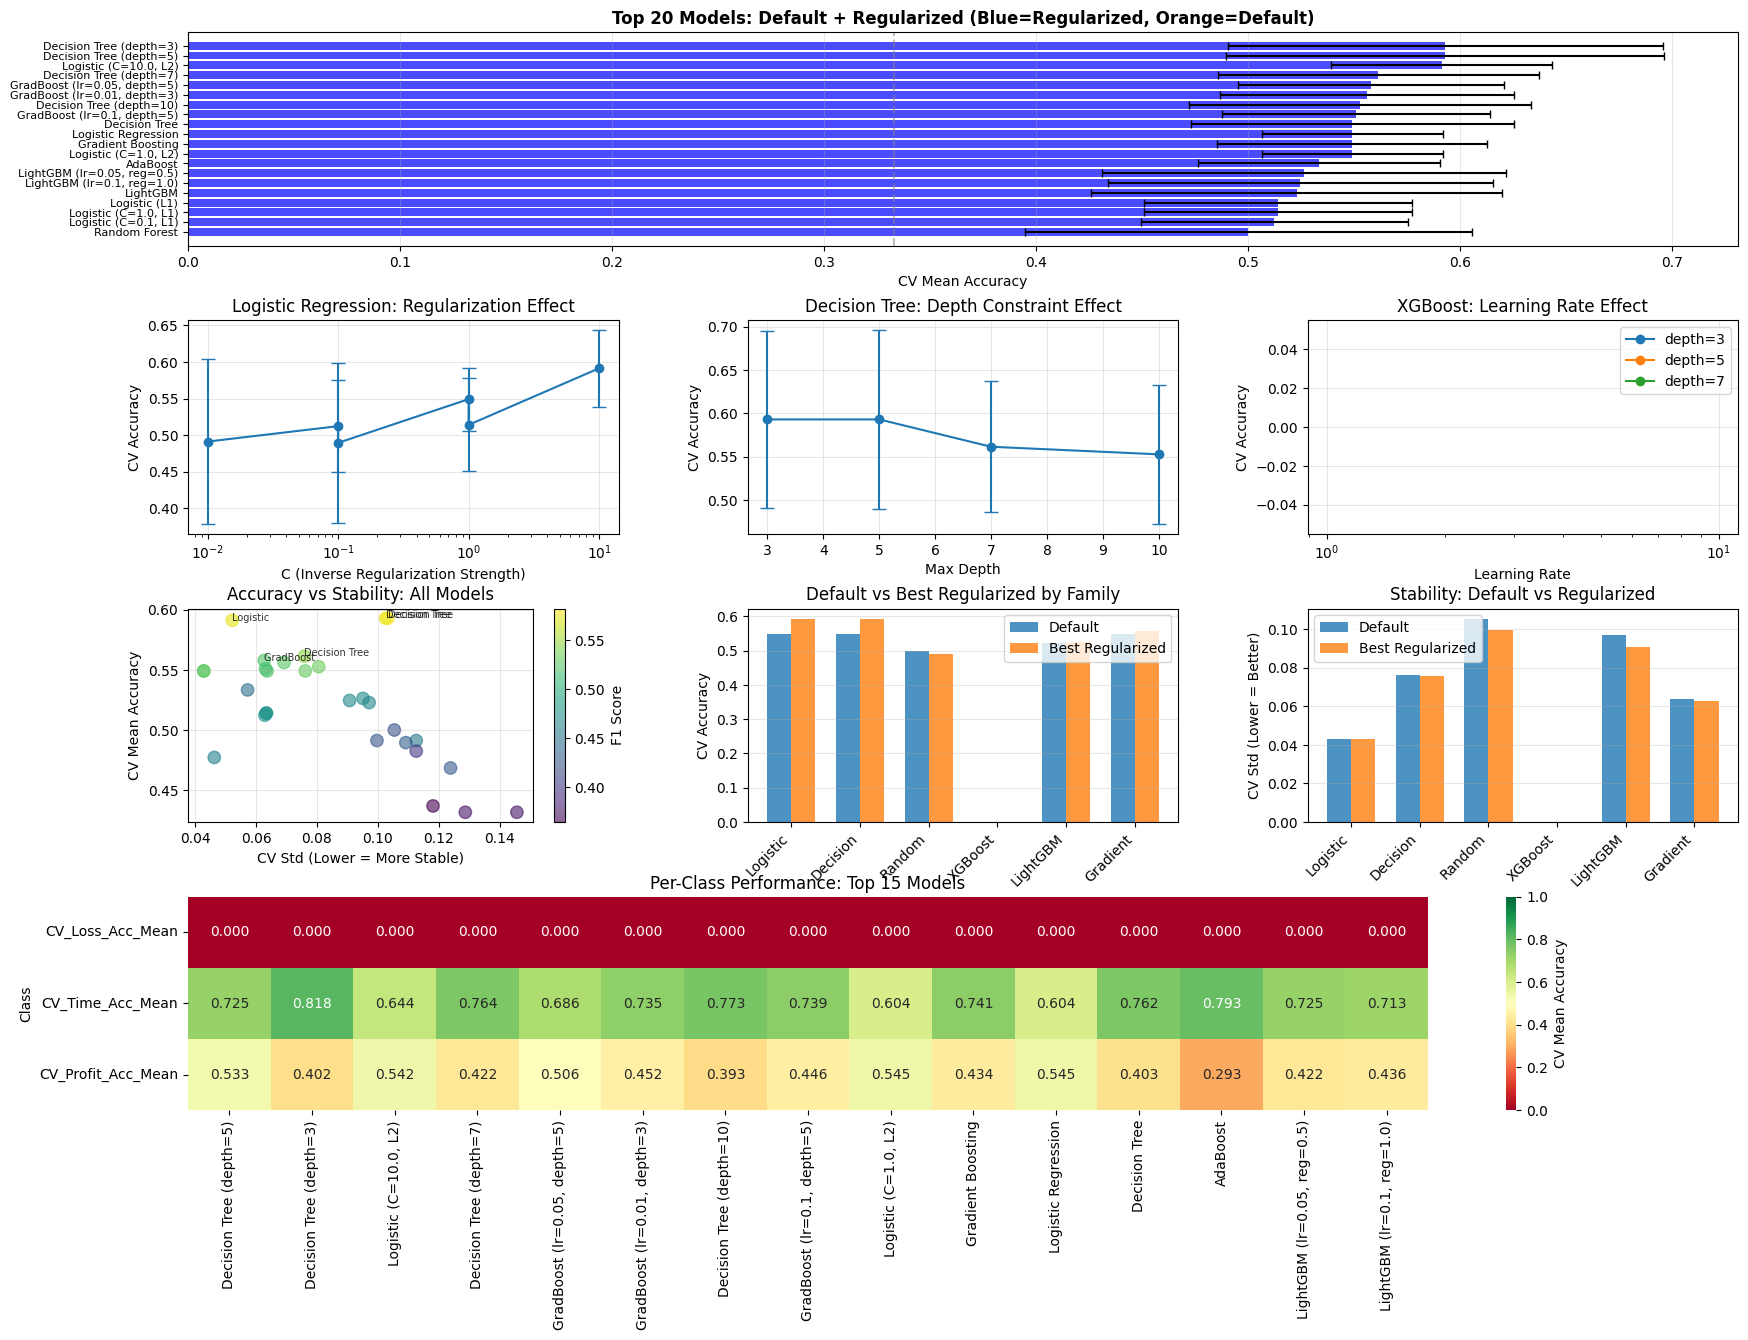

In [22]:
# ============================================================================
# REGULARIZATION RESULTS DATAFRAME
# ============================================================================

reg_cv_results_df = pd.DataFrame(reg_cv_results)
reg_cv_results_df = reg_cv_results_df.sort_values('CV_Accuracy_Mean', ascending=False)

reg_cv_results_df.to_csv('regularized_models_cv_results.csv', index=False)

print(f"\n✓ Regularized results saved to 'regularized_models_cv_results.csv'")
print(f"✓ Combined results saved to 'all_models_combined_results.csv'")

print("\n" + "="*80)
print("REGULARIZATION CV RESULTS")
print("="*80)

print("\n📊 Top 10 Regularized Models (by CV Accuracy):")
display_cols = ['Model', 'CV_Accuracy_Mean', 'CV_Accuracy_Std', 'CV_F1_Mean']
print(reg_cv_results_df[display_cols].head(10).to_string(index=False))

# ============================================================================
# COMPARE DEFAULT VS REGULARIZED
# ============================================================================

print("\n" + "="*80)
print("DEFAULT vs REGULARIZED COMPARISON")
print("="*80)

# Group by model family
def get_model_family(name):
    if 'Logistic' in name:
        return 'Logistic Regression'
    elif 'Decision Tree' in name:
        return 'Decision Tree'
    elif 'RF' in name or 'Random Forest' in name:
        return 'Random Forest'
    elif 'XGBoost' in name:
        return 'XGBoost'
    elif 'LightGBM' in name:
        return 'LightGBM'
    elif 'GradBoost' in name or 'Gradient Boosting' in name:
        return 'Gradient Boosting'
    else:
        return 'Other'

# Add family column to both dataframes
cv_results_df['Family'] = cv_results_df['Model'].apply(get_model_family)
reg_cv_results_df['Family'] = reg_cv_results_df['Model'].apply(get_model_family)

# Compare by family
print("\nBest Performance by Model Family:")
print(f"{'Family':<20} {'Best Default':<10} {'Best Regularized':<10} {'Improvement':<12}")
print("─" * 80)

for family in ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting']:
    default_best = cv_results_df[cv_results_df['Family'] == family]['CV_Accuracy_Mean'].max()
    reg_best = reg_cv_results_df[reg_cv_results_df['Family'] == family]['CV_Accuracy_Mean'].max()
    
    if not np.isnan(default_best) and not np.isnan(reg_best):
        improvement = reg_best - default_best
        improvement_str = f"{improvement:+.4f}"
        print(f"{family:<20} {default_best:.4f}     {reg_best:.4f}     {improvement_str}")

# ============================================================================
# REGULARIZATION ANALYSIS BY MODEL TYPE
# ============================================================================

print("\n" + "="*80)
print("REGULARIZATION IMPACT ANALYSIS")
print("="*80)

# Logistic Regression - C parameter effect
print("\n1. Logistic Regression (C parameter - inverse regularization strength):")
logistic_results = reg_cv_results_df[reg_cv_results_df['Family'] == 'Logistic Regression'].copy()
logistic_results['C_value'] = logistic_results['Model'].str.extract(r'C=([0-9.]+)').astype(float)
logistic_results = logistic_results.sort_values('C_value')
print(logistic_results[['Model', 'CV_Accuracy_Mean', 'CV_Accuracy_Std']].to_string(index=False))

# Decision Tree - depth effect
print("\n2. Decision Tree (max_depth constraint):")
tree_results = reg_cv_results_df[reg_cv_results_df['Family'] == 'Decision Tree'].copy()
tree_results['depth'] = tree_results['Model'].str.extract(r'depth=([0-9]+)').astype(float)
tree_results = tree_results.sort_values('depth')
print(tree_results[['Model', 'CV_Accuracy_Mean', 'CV_Accuracy_Std']].to_string(index=False))

# XGBoost - learning rate effect
print("\n3. XGBoost (learning rate + depth):")
xgb_results = reg_cv_results_df[reg_cv_results_df['Family'] == 'XGBoost']
print(xgb_results[['Model', 'CV_Accuracy_Mean', 'CV_Accuracy_Std']].to_string(index=False))

# ============================================================================
# COMBINED COMPARISON: ALL MODELS
# ============================================================================

# Combine default and regularized results
all_models_df = pd.concat([cv_results_df, reg_cv_results_df], ignore_index=True)
all_models_df = all_models_df.sort_values('CV_Accuracy_Mean', ascending=False)
all_models_df.to_csv('all_models_combined_results.csv', index=False)


print("\n" + "="*80)
print("OVERALL BEST MODELS (Default + Regularized)")
print("="*80)

print("\n🏆 Top 15 Models Overall:")
print(all_models_df[['Model', 'CV_Accuracy_Mean', 'CV_Accuracy_Std', 'CV_F1_Mean']].head(15).to_string(index=False))

# ============================================================================
# STABILITY COMPARISON
# ============================================================================

print("\n" + "="*80)
print("STABILITY COMPARISON (Lower Std = More Stable)")
print("="*80)

print("\n📊 Most Stable Models (Lowest CV Std):")
most_stable = all_models_df.nsmallest(10, 'CV_Accuracy_Std')
print(most_stable[['Model', 'CV_Accuracy_Mean', 'CV_Accuracy_Std']].to_string(index=False))

# Check if regularization improved stability
print("\n📊 Stability Improvement Analysis:")
for family in ['Logistic Regression', 'XGBoost', 'LightGBM']:
    default_std = cv_results_df[cv_results_df['Family'] == family]['CV_Accuracy_Std'].min()
    reg_std = reg_cv_results_df[reg_cv_results_df['Family'] == family]['CV_Accuracy_Std'].min()
    
    if not np.isnan(default_std) and not np.isnan(reg_std):
        improvement = default_std - reg_std
        if improvement > 0:
            print(f"   ✓ {family}: Regularization reduced std by {improvement:.4f}")
        else:
            print(f"   ✗ {family}: Regularization increased std by {abs(improvement):.4f}")

# ============================================================================
# VISUALIZATIONS
# ============================================================================

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# 1. Overall Comparison: Top 20 Models
ax1 = fig.add_subplot(gs[0, :])
top_20 = all_models_df.head(20).sort_values('CV_Accuracy_Mean', ascending=True)
colors = ['blue' if 'Default' not in str(row['Model']) else 'orange' 
          for _, row in top_20.iterrows()]
y_pos = np.arange(len(top_20))
ax1.barh(y_pos, top_20['CV_Accuracy_Mean'], xerr=top_20['CV_Accuracy_Std'],
         alpha=0.7, color=colors, capsize=3)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(top_20['Model'], fontsize=8)
ax1.set_xlabel('CV Mean Accuracy')
ax1.set_title('Top 20 Models: Default + Regularized (Blue=Regularized, Orange=Default)', 
              fontsize=12, fontweight='bold')
ax1.axvline(0.333, color='gray', linestyle='--', alpha=0.5)
ax1.grid(axis='x', alpha=0.3)

# 2. Logistic Regression: C parameter effect
ax2 = fig.add_subplot(gs[1, 0])
logistic_plot = reg_cv_results_df[reg_cv_results_df['Family'] == 'Logistic Regression'].copy()
if len(logistic_plot) > 0:
    logistic_plot['C'] = logistic_plot['Model'].str.extract(r'C=([0-9.]+)').astype(float)
    logistic_plot = logistic_plot.dropna(subset=['C']).sort_values('C')
    
    ax2.errorbar(logistic_plot['C'], logistic_plot['CV_Accuracy_Mean'], 
                 yerr=logistic_plot['CV_Accuracy_Std'], marker='o', capsize=5)
    ax2.set_xscale('log')
    ax2.set_xlabel('C (Inverse Regularization Strength)')
    ax2.set_ylabel('CV Accuracy')
    ax2.set_title('Logistic Regression: Regularization Effect')
    ax2.grid(alpha=0.3)

# 3. Tree Depth Effect
ax3 = fig.add_subplot(gs[1, 1])
tree_plot = reg_cv_results_df[reg_cv_results_df['Family'] == 'Decision Tree'].copy()
if len(tree_plot) > 0:
    tree_plot['depth'] = tree_plot['Model'].str.extract(r'depth=([0-9]+)').astype(float)
    tree_plot = tree_plot.dropna(subset=['depth']).sort_values('depth')
    
    ax3.errorbar(tree_plot['depth'], tree_plot['CV_Accuracy_Mean'],
                 yerr=tree_plot['CV_Accuracy_Std'], marker='o', capsize=5)
    ax3.set_xlabel('Max Depth')
    ax3.set_ylabel('CV Accuracy')
    ax3.set_title('Decision Tree: Depth Constraint Effect')
    ax3.grid(alpha=0.3)

# 4. XGBoost Learning Rate Effect
ax4 = fig.add_subplot(gs[1, 2])
xgb_plot = reg_cv_results_df[reg_cv_results_df['Family'] == 'XGBoost'].copy()
if len(xgb_plot) > 0:
    xgb_plot['lr'] = xgb_plot['Model'].str.extract(r'lr=([0-9.]+)').astype(float)
    xgb_plot = xgb_plot.dropna(subset=['lr']).sort_values('lr')
    
    for depth in xgb_plot['Model'].str.extract(r'depth=([0-9]+)')[0].dropna().unique():
        depth_data = xgb_plot[xgb_plot['Model'].str.contains(f'depth={depth}')]
        ax4.plot(depth_data['lr'], depth_data['CV_Accuracy_Mean'], 
                marker='o', label=f'depth={depth}')
    
    ax4.set_xscale('log')
    ax4.set_xlabel('Learning Rate')
    ax4.set_ylabel('CV Accuracy')
    ax4.set_title('XGBoost: Learning Rate Effect')
    ax4.legend()
    ax4.grid(alpha=0.3)

# 5. Accuracy vs Stability (All Models)
ax5 = fig.add_subplot(gs[2, 0])
scatter = ax5.scatter(all_models_df['CV_Accuracy_Std'], all_models_df['CV_Accuracy_Mean'],
                     s=80, c=all_models_df['CV_F1_Mean'], cmap='viridis', alpha=0.6)
ax5.set_xlabel('CV Std (Lower = More Stable)')
ax5.set_ylabel('CV Mean Accuracy')
ax5.set_title('Accuracy vs Stability: All Models')
plt.colorbar(scatter, ax=ax5, label='F1 Score')
ax5.grid(alpha=0.3)

# Add best models annotation
best_5 = all_models_df.head(5)
for _, row in best_5.iterrows():
    ax5.annotate(row['Model'].split('(')[0][:15], 
                (row['CV_Accuracy_Std'], row['CV_Accuracy_Mean']),
                fontsize=7, alpha=0.8)

# 6. Default vs Best Regularized by Family
ax6 = fig.add_subplot(gs[2, 1])
families = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting']
default_scores = []
reg_scores = []

for family in families:
    default = cv_results_df[cv_results_df['Family'] == family]['CV_Accuracy_Mean'].max()
    reg = reg_cv_results_df[reg_cv_results_df['Family'] == family]['CV_Accuracy_Mean'].max()
    default_scores.append(default if not np.isnan(default) else 0)
    reg_scores.append(reg if not np.isnan(reg) else 0)

x = np.arange(len(families))
width = 0.35
ax6.bar(x - width/2, default_scores, width, label='Default', alpha=0.8)
ax6.bar(x + width/2, reg_scores, width, label='Best Regularized', alpha=0.8)
ax6.set_ylabel('CV Accuracy')
ax6.set_title('Default vs Best Regularized by Family')
ax6.set_xticks(x)
ax6.set_xticklabels([f.split()[0] for f in families], rotation=45, ha='right')
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

# 7. Stability by Family
ax7 = fig.add_subplot(gs[2, 2])
default_stds = []
reg_stds = []

for family in families:
    default = cv_results_df[cv_results_df['Family'] == family]['CV_Accuracy_Std'].min()
    reg = reg_cv_results_df[reg_cv_results_df['Family'] == family]['CV_Accuracy_Std'].min()
    default_stds.append(default if not np.isnan(default) else 0)
    reg_stds.append(reg if not np.isnan(reg) else 0)

ax7.bar(x - width/2, default_stds, width, label='Default', alpha=0.8)
ax7.bar(x + width/2, reg_stds, width, label='Best Regularized', alpha=0.8)
ax7.set_ylabel('CV Std (Lower = Better)')
ax7.set_title('Stability: Default vs Regularized')
ax7.set_xticks(x)
ax7.set_xticklabels([f.split()[0] for f in families], rotation=45, ha='right')
ax7.legend()
ax7.grid(axis='y', alpha=0.3)

# 8. Per-Class Performance Heatmap (Top 15)
ax8 = fig.add_subplot(gs[3, :])
top_15_class = all_models_df.head(15)[['Model', 'CV_Loss_Acc_Mean', 
                                        'CV_Time_Acc_Mean', 'CV_Profit_Acc_Mean']].set_index('Model')
sns.heatmap(top_15_class.T, annot=True, fmt='.3f', cmap='RdYlGn',
            vmin=0, vmax=1, ax=ax8, cbar_kws={'label': 'CV Mean Accuracy'})
ax8.set_title('Per-Class Performance: Top 15 Models')
ax8.set_xlabel('')
ax8.set_ylabel('Class')

plt.savefig('regularization_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [23]:

# view results dataframe
reg_cv_results_df.to_csv('regularized_models_cv_results.csv', index=False)
reg_cv_results_df = pd.read_csv('regularized_models_cv_results.csv')

# Create composite score for final ranking - assign weights based on what matters in trading context
reg_cv_results_df['Composite_Score'] = (
    reg_cv_results_df['CV_Precision_Mean'] * 0.4 + # Are Signals High Quality?
    (1 - reg_cv_results_df['CV_Accuracy_Std']) * 0.2 + # Is Performance Stable across regimes? (invert std so higher is better)
    reg_cv_results_df['CV_Profit_Acc_Mean'] * 0.4 # Can it find winning trades?
)

# Sharpe-inspired metric: Mean Accuracy / Std Dev
reg_cv_results_df['Sharpe_"ish"_ratio'] = (
    reg_cv_results_df['CV_Accuracy_Mean'] / (reg_cv_results_df['CV_Accuracy_Std']))

# Models with best Per-Class Accuracy - You care if model correctly predicts profit targets (label=1), If Profit_Accuracy is low, model can't identify winning trades
top_profit_models = reg_cv_results_df.sort_values('CV_Profit_Acc_Mean', ascending=False)
print("\nTop Models for Profit Class Accuracy:", top_profit_models[['Model', 'CV_Profit_Acc_Mean']].head(10))

# Models with best CV Accuracy Stability - You care about consistent performance across time, low Std Dev indicates reliability in different regimes - High std = model works in some periods, fails in others (dangerous for live trading)
stable_models = reg_cv_results_df.sort_values('CV_Accuracy_Std')
print("\nMost Stable Models (Low Std Dev):", stable_models[['Model', 'CV_Accuracy_Std']].head(10))

# Models with Precision for Profit Class - You care about minimizing false positives when predicting profitable trades (label=1), high precision means when model predicts profit, it's usually correct
top_precision_models = reg_cv_results_df.sort_values('CV_Precision_Mean', ascending=False)
print("\nTop Models for Precision:", top_precision_models[['Model', 'CV_Precision_Mean']].head(10))

# Models with best Composite Score - Balanced performance across key metrics
top_composite_models = reg_cv_results_df.sort_values('Composite_Score', ascending=False)
print("\nTop Models by Composite Score:", top_composite_models[['Model', 'Composite_Score']].head(10))

# Models with best Sharpe-"ish" Ratio - risk adjusted performance
top_sharpe_models = reg_cv_results_df.sort_values('Sharpe_"ish"_ratio', ascending=False)
print("\nTop Models by Sharpe-'ish' Ratio:", top_sharpe_models[['Model', 'Sharpe_"ish"_ratio']].head(10))



Top Models for Profit Class Accuracy:                            Model  CV_Profit_Acc_Mean
12          Logistic (C=0.1, L1)            0.575360
11          Logistic (C=1.0, L1)            0.547673
8           Logistic (C=1.0, L2)            0.544850
2          Logistic (C=10.0, L2)            0.542140
1        Decision Tree (depth=5)            0.532943
4   GradBoost (lr=0.05, depth=5)            0.505509
15          Logistic (C=0.1, L2)            0.503889
14         Logistic (C=0.01, L2)            0.483329
5   GradBoost (lr=0.01, depth=3)            0.452360
7    GradBoost (lr=0.1, depth=5)            0.445772

Most Stable Models (Low Std Dev):                            Model  CV_Accuracy_Std
8           Logistic (C=1.0, L2)         0.042830
2          Logistic (C=10.0, L2)         0.052221
4   GradBoost (lr=0.05, depth=5)         0.062669
12          Logistic (C=0.1, L1)         0.062914
7    GradBoost (lr=0.1, depth=5)         0.063109
11          Logistic (C=1.0, L1)         0.

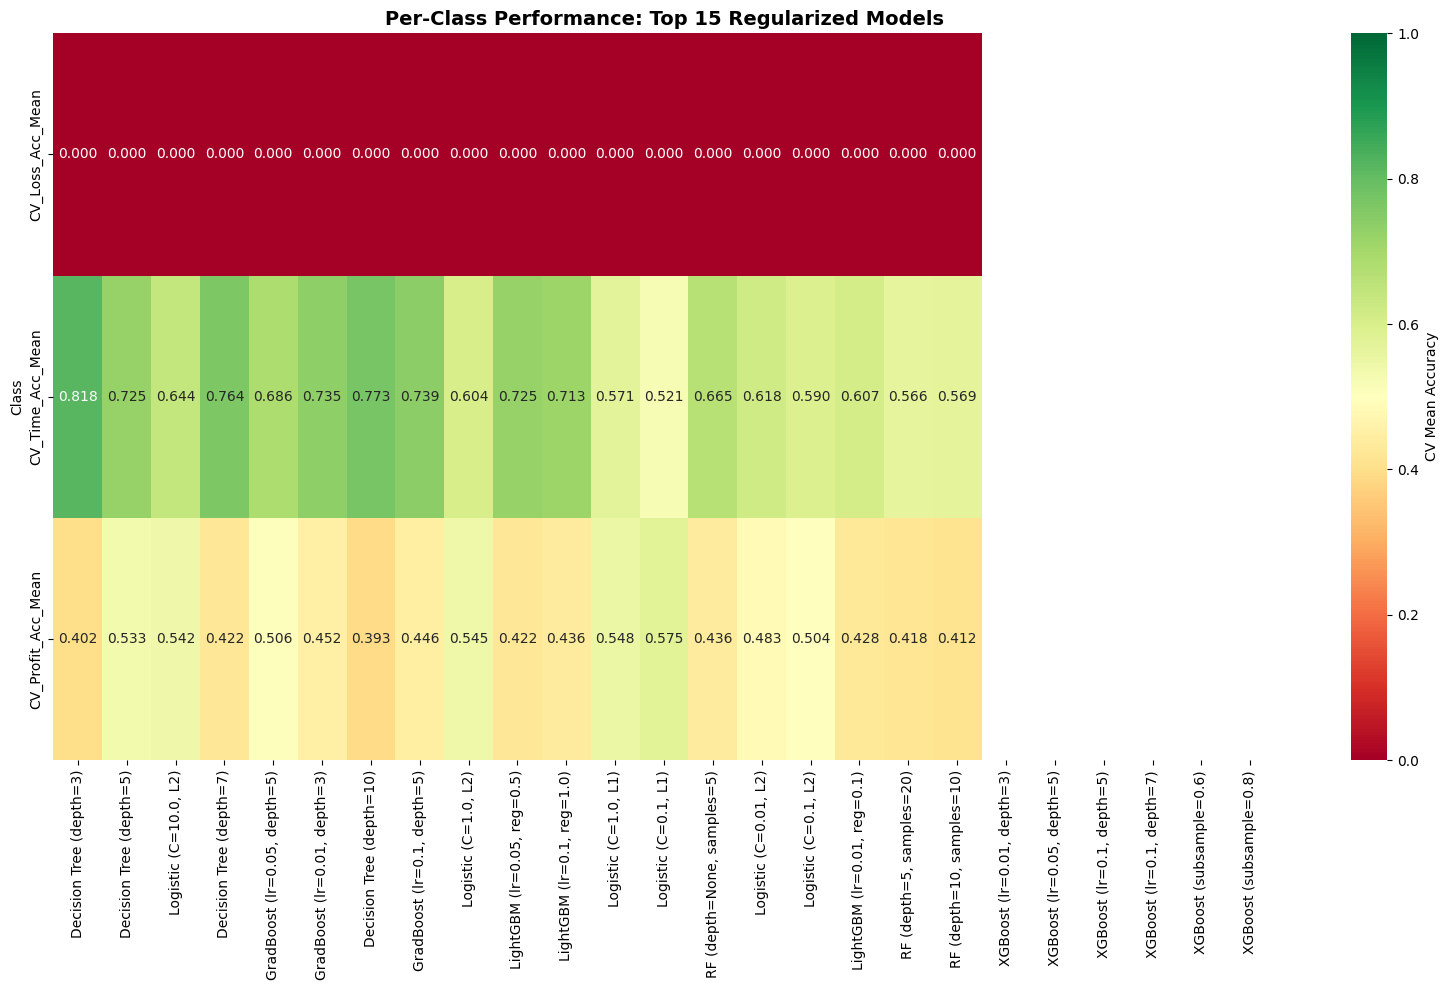


✓ Regularized models heatmap generated


In [24]:
# Create heatmap for regularized models
plt.figure(figsize=(16, 10))

# Get top 15 models
top_15 = reg_cv_results_df[['Model', 'CV_Loss_Acc_Mean', 
                                       'CV_Time_Acc_Mean', 
                                       'CV_Profit_Acc_Mean']].set_index('Model')

sns.heatmap(top_15.T, annot=True, fmt='.3f', cmap='RdYlGn',
            vmin=0, vmax=1, cbar_kws={'label': 'CV Mean Accuracy'})
plt.title('Per-Class Performance: Top 15 Regularized Models', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('Class')
plt.tight_layout()
plt.show()

print("\n✓ Regularized models heatmap generated")

#### Hyperpapram Tuning for best model 

In [25]:
# ============================================================================
# LIGHTGBM BAYESIAN OPTIMIZATION - COMPREHENSIVE PIPELINE
# ============================================================================
# Using Optuna for intelligent hyperparameter search
# Much faster than grid search while finding better or equal results
#
# INSTALLATION REQUIRED:
# pip install optuna --break-system-packages
#
# Optional (for visualization):
# pip install plotly --break-system-packages
# ============================================================================

# ============================================================================
# CONFIGURATION: CHOOSE WHAT TO OPTIMIZE
# ============================================================================

OPTIMIZATION_TARGET = 'composite'  # ← CHANGE THIS TO SET YOUR OBJECTIVE!

"""
Available optimization targets:

1. 'composite'         - Balanced: precision + profit accuracy + stability
                        Uses custom weights below (recommended for most cases)

2. 'profit'            - Pure profit class accuracy
                        Best for: Maximizing winning trade detection

3. 'precision'         - Pure precision (minimize false positives)
                        Best for: High-quality signals, avoid bad trades

4. 'accuracy'          - Overall accuracy across all classes
                        Best for: General model performance

5. 'f1'                - F1 score (harmonic mean of precision/recall)
                        Best for: Balanced precision and recall

6. 'profit_precision'  - Weighted: 60% profit accuracy + 40% precision
                        Best for: Finding profits while staying precise

7. 'profit_stable'     - Profit accuracy with stability penalty
                        Best for: Consistent profit detection across regimes

8. 'sharpe_style'      - Risk-adjusted: profit accuracy / std dev
                        Best for: Maximum risk-adjusted performance

9. 'loss_profit'       - Weighted: 50% profit + 50% loss class accuracy
                        Best for: Balanced entry/exit signal quality

10. 'all_classes'      - Weighted: equal weight to all 3 classes
                        Best for: Balanced multi-class performance
"""

# Custom weights (only used if OPTIMIZATION_TARGET = 'composite')
WEIGHT_PRECISION = 0.4      # How much you care about signal quality
WEIGHT_STABILITY = 0.2      # How much you care about consistency
WEIGHT_PROFIT = 0.4         # How much you care about catching profits

# Optuna settings
N_TRIALS = 100              # Number of hyperparameter combinations to test
RANDOM_SEED = 42            # For reproducibility
N_CV_SPLITS = 5             # Number of cross-validation folds
EMBARGO_BARS = 20           # Embargo period (should match time_bars in labeling)

print("="*80)
print("OPTIMIZATION CONFIGURATION")
print("="*80)
print(f"\n🎯 Optimization Target: {OPTIMIZATION_TARGET}")
if OPTIMIZATION_TARGET == 'composite':
    print(f"   Weights: Precision={WEIGHT_PRECISION}, Stability={WEIGHT_STABILITY}, Profit={WEIGHT_PROFIT}")
print(f"⚙️  Trials: {N_TRIALS}")
print(f"🔄 CV Folds: {N_CV_SPLITS}")
print(f"🚧 Embargo: {EMBARGO_BARS} bars")

# ============================================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix)
from lightgbm import LGBMClassifier
import time
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.visualization import (plot_optimization_history, 
                                   plot_param_importances,
                                   plot_parallel_coordinate)

# Suppress Optuna's verbose output
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("="*80)
print("LIGHTGBM BAYESIAN OPTIMIZATION (OPTUNA)")
print("="*80)
print("\n🎯 Goal: Find optimal LightGBM configuration for crypto trading")
print("🔬 Method: Bayesian Optimization (Optuna)")
print("📊 Using: FULL dataset with 5-fold time series CV + embargo")
print("⚡ Speed: 10-20x faster than grid search")
print("🎨 Quality: Often finds better solutions than grid search")

# ============================================================================
# STEP 1: LOAD FULL DATASET
# ============================================================================

print("\n" + "="*80)
print("STEP 1: LOADING FULL DATASET")
print("="*80)

# Use the FULL dataset (not sampled)
df_full = df.copy()
df_full = df_full.dropna().reset_index(drop=True)

print(f"✓ Full dataset: {len(df_full)} rows")

# Feature selection
feature_cols = [
    'cvd', 'cvd_slope_5', 'cvd_slope_10',
    'avg_buy_sell_ratio_5', 'avg_buy_sell_ratio_10',
    'atr_14', 'adx_14', 'momentum_10', 'roc_10',
    'trend_regime', 'trend_alignment', 
    'consecutive_up', 'consecutive_down',
    'close_lag1', 'ema_10', 'sma_50'
]

X_full = df_full[feature_cols]
y_full = df_full['label']

print(f"✓ Features: {len(feature_cols)} columns")
print(f"✓ Label distribution:")
label_dist = y_full.value_counts(normalize=True).sort_index()
for label in [-1, 0, 1]:
    label_name = {-1: "Loss", 0: "Time", 1: "Profit"}[label]
    print(f"   {label_name} ({label:2d}): {label_dist[label]:.1%} ({(y_full==label).sum()} samples)")

# Train/test split (80/20)
split_idx = int(len(df_full) * 0.8)
X_train_full = X_full.iloc[:split_idx]
X_test_full = X_full.iloc[split_idx:]
y_train_full = y_full.iloc[:split_idx]
y_test_full = y_full.iloc[split_idx:]

print(f"\n✓ Train set: {len(X_train_full)} rows")
print(f"✓ Test set: {len(X_test_full)} rows")

# Encode labels for LightGBM (requires 0-indexed)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_full)
y_test_encoded = label_encoder.transform(y_test_full)

# Features to scale
features_to_scale = [
    'cvd', 'cvd_slope_5', 'cvd_slope_10',
    'atr_14', 'momentum_10',
    'consecutive_up', 'consecutive_down',
    'close_lag1', 'ema_10', 'sma_50'
]

# ============================================================================
# STEP 2: DEFINE EMBARGO FUNCTION
# ============================================================================

def purge_embargo_cv(train_idx, val_idx, embargo_bars=20):
    """Remove training samples that overlap with test period."""
    if len(val_idx) == 0:
        return train_idx, val_idx
    
    test_start = val_idx[0]
    train_idx = train_idx[train_idx < test_start - embargo_bars]
    
    return train_idx, val_idx

# ============================================================================
# STEP 3: CROSS-VALIDATION OBJECTIVE FUNCTION
# ============================================================================

def objective(trial):
    """
    Optuna objective function.
    Returns the metric specified by OPTIMIZATION_TARGET to MAXIMIZE.
    """
    
    # Suggest hyperparameters
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 15, 255),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
    }
    
    # Additional dart-specific parameters
    if params['boosting_type'] == 'dart':
        params['drop_rate'] = trial.suggest_float('drop_rate', 0.0, 0.5)
        params['skip_drop'] = trial.suggest_float('skip_drop', 0.0, 0.5)
    
    # Cross-validation
    tscv = TimeSeriesSplit(n_splits=N_CV_SPLITS)
    
    fold_scores = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'loss_acc': [],
        'time_acc': [],
        'profit_acc': []
    }
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_full)):
        # Apply embargo
        train_idx, val_idx = purge_embargo_cv(train_idx, val_idx, embargo_bars=EMBARGO_BARS)
        
        if len(train_idx) == 0 or len(val_idx) == 0:
            continue
        
        # Split data
        X_fold_train = X_train_full.iloc[train_idx].copy()
        X_fold_val = X_train_full.iloc[val_idx].copy()
        y_fold_train = y_train_encoded[train_idx]
        y_fold_val = y_train_encoded[val_idx]
        
        # Get original labels for metrics
        y_fold_val_original = y_train_full.iloc[val_idx]
        
        # Scale
        fold_scaler = RobustScaler()
        X_fold_train_scaled = X_fold_train.copy()
        X_fold_train_scaled[features_to_scale] = fold_scaler.fit_transform(
            X_fold_train[features_to_scale]
        )
        
        X_fold_val_scaled = X_fold_val.copy()
        X_fold_val_scaled[features_to_scale] = fold_scaler.transform(
            X_fold_val[features_to_scale]
        )
        
        # Train model
        model = LGBMClassifier(
            **params,
            random_state=RANDOM_SEED,
            class_weight='balanced',
            verbose=-1,
            n_jobs=1  # Prevent nested parallelism
        )
        
        try:
            model.fit(X_fold_train_scaled, y_fold_train)
            
            # Predict
            y_fold_pred = model.predict(X_fold_val_scaled)
            y_fold_pred = label_encoder.inverse_transform(y_fold_pred)
            
            # Metrics
            fold_scores['accuracy'].append(accuracy_score(y_fold_val_original, y_fold_pred))
            fold_scores['precision'].append(precision_score(y_fold_val_original, y_fold_pred,
                                                            average='weighted', zero_division=0))
            fold_scores['recall'].append(recall_score(y_fold_val_original, y_fold_pred,
                                                      average='weighted', zero_division=0))
            fold_scores['f1'].append(f1_score(y_fold_val_original, y_fold_pred,
                                              average='weighted', zero_division=0))
            
            # Per-class accuracy
            for label, key in [(-1, 'loss_acc'), (0, 'time_acc'), (1, 'profit_acc')]:
                mask = y_fold_val_original == label
                if mask.sum() > 0:
                    class_acc = accuracy_score(y_fold_val_original[mask], y_fold_pred[mask])
                    fold_scores[key].append(class_acc)
                else:
                    fold_scores[key].append(np.nan)
        
        except Exception as e:
            # If training fails, return poor score
            return 0.0
    
    # Calculate ALL metrics
    cv_accuracy_mean = np.mean(fold_scores['accuracy'])
    cv_accuracy_std = np.std(fold_scores['accuracy'])
    cv_precision_mean = np.mean(fold_scores['precision'])
    cv_recall_mean = np.mean(fold_scores['recall'])
    cv_f1_mean = np.mean(fold_scores['f1'])
    cv_loss_acc_mean = np.nanmean(fold_scores['loss_acc'])
    cv_time_acc_mean = np.nanmean(fold_scores['time_acc'])
    cv_profit_acc_mean = np.nanmean(fold_scores['profit_acc'])
    
    # Store ALL metrics in trial for later analysis
    trial.set_user_attr('cv_accuracy_mean', cv_accuracy_mean)
    trial.set_user_attr('cv_accuracy_std', cv_accuracy_std)
    trial.set_user_attr('cv_precision_mean', cv_precision_mean)
    trial.set_user_attr('cv_recall_mean', cv_recall_mean)
    trial.set_user_attr('cv_f1_mean', cv_f1_mean)
    trial.set_user_attr('cv_loss_acc_mean', cv_loss_acc_mean)
    trial.set_user_attr('cv_time_acc_mean', cv_time_acc_mean)
    trial.set_user_attr('cv_profit_acc_mean', cv_profit_acc_mean)
    
    # ========================================================================
    # SELECT OBJECTIVE BASED ON CONFIGURATION
    # ========================================================================
    
    if OPTIMIZATION_TARGET == 'composite':
        # Balanced: precision + profit + stability
        score = (
            cv_precision_mean * WEIGHT_PRECISION +
            (1 - cv_accuracy_std) * WEIGHT_STABILITY +
            cv_profit_acc_mean * WEIGHT_PROFIT
        )
    
    elif OPTIMIZATION_TARGET == 'profit':
        # Pure profit class accuracy
        score = cv_profit_acc_mean
    
    elif OPTIMIZATION_TARGET == 'precision':
        # Pure precision
        score = cv_precision_mean
    
    elif OPTIMIZATION_TARGET == 'accuracy':
        # Overall accuracy
        score = cv_accuracy_mean
    
    elif OPTIMIZATION_TARGET == 'f1':
        # F1 score
        score = cv_f1_mean
    
    elif OPTIMIZATION_TARGET == 'profit_precision':
        # 60% profit accuracy + 40% precision
        score = cv_profit_acc_mean * 0.6 + cv_precision_mean * 0.4
    
    elif OPTIMIZATION_TARGET == 'profit_stable':
        # Profit accuracy with stability penalty
        score = cv_profit_acc_mean - (cv_accuracy_std * 0.5)
    
    elif OPTIMIZATION_TARGET == 'sharpe_style':
        # Risk-adjusted: profit accuracy / std dev
        score = cv_profit_acc_mean / (cv_accuracy_std + 1e-6)
    
    elif OPTIMIZATION_TARGET == 'loss_profit':
        # Balance loss and profit class accuracy
        score = cv_loss_acc_mean * 0.5 + cv_profit_acc_mean * 0.5
    
    elif OPTIMIZATION_TARGET == 'all_classes':
        # Equal weight to all three classes
        score = (cv_loss_acc_mean + cv_time_acc_mean + cv_profit_acc_mean) / 3
    
    else:
        raise ValueError(f"Unknown OPTIMIZATION_TARGET: '{OPTIMIZATION_TARGET}'. "
                        f"Valid options: composite, profit, precision, accuracy, f1, "
                        f"profit_precision, profit_stable, sharpe_style, loss_profit, all_classes")
    
    return score

# ============================================================================
# STEP 4: RUN BAYESIAN OPTIMIZATION
# ============================================================================

print("\n" + "="*80)
print("STEP 4: BAYESIAN OPTIMIZATION")
print("="*80)

print(f"\n🔬 Creating Optuna study...")
print(f"   Objective: MAXIMIZE {OPTIMIZATION_TARGET}")
if OPTIMIZATION_TARGET == 'composite':
    print(f"   Weights: Precision={WEIGHT_PRECISION}, Stability={WEIGHT_STABILITY}, Profit={WEIGHT_PROFIT}")
print(f"   Method: Tree-structured Parzen Estimator (TPE)")
print(f"   Trials: {N_TRIALS} (can stop early if no improvement)")

# Create study
study = optuna.create_study(
    direction='maximize',  # Maximize the selected objective
    sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED),  # Bayesian optimization
    study_name='lightgbm_trading_optimization'
)

# Custom callback for progress tracking
class ProgressCallback:
    def __init__(self, n_trials):
        self.n_trials = n_trials
        self.start_time = time.time()
        self.best_score = 0.0
        
    def __call__(self, study, trial):
        current_trial = len(study.trials)
        elapsed = time.time() - self.start_time
        avg_time_per_trial = elapsed / current_trial
        remaining = avg_time_per_trial * (self.n_trials - current_trial)
        
        if trial.value > self.best_score:
            self.best_score = trial.value
            improvement = "🎯 NEW BEST!"
        else:
            improvement = ""
        
        if current_trial % 5 == 0 or current_trial == self.n_trials:
            print(f"Trial {current_trial:3d}/{self.n_trials} | "
                  f"Score: {trial.value:.4f} | "
                  f"Best: {self.best_score:.4f} | "
                  f"Elapsed: {elapsed/60:.1f}min | "
                  f"ETA: {remaining/60:.1f}min {improvement}")

print(f"\n⚡ Starting optimization with {N_TRIALS} trials...")
print("   Initial 10 trials: Random sampling (exploration)")
print("   Remaining trials: Bayesian optimization (exploitation)\n")

# Run optimization
study.optimize(
    objective,
    n_trials=N_TRIALS,
    callbacks=[ProgressCallback(N_TRIALS)],
    show_progress_bar=False,
    n_jobs=1  # Sequential execution for stability
)

print("\n✓ Optimization complete!")

# ============================================================================
# STEP 5: ANALYZE RESULTS
# ============================================================================

print("\n" + "="*80)
print("STEP 5: OPTIMIZATION RESULTS")
print("="*80)

best_trial = study.best_trial

print(f"\n🎯 OPTIMIZATION TARGET: {OPTIMIZATION_TARGET}")
print(f"🏆 BEST TRIAL: #{best_trial.number}")
print(f"   Score ({OPTIMIZATION_TARGET}): {best_trial.value:.4f}")
print(f"\n📊 BEST HYPERPARAMETERS:")
print("="*80)
for param, value in best_trial.params.items():
    print(f"   {param:20s}: {value}")

print(f"\n📊 BEST CV METRICS (ALL):")
print("="*80)
print(f"   CV Accuracy:        {best_trial.user_attrs['cv_accuracy_mean']:.4f} "
      f"(±{best_trial.user_attrs['cv_accuracy_std']:.4f})")
print(f"   CV Precision:       {best_trial.user_attrs['cv_precision_mean']:.4f}")
print(f"   CV Recall:          {best_trial.user_attrs['cv_recall_mean']:.4f}")
print(f"   CV F1:              {best_trial.user_attrs['cv_f1_mean']:.4f}")
print(f"   CV Loss Accuracy:   {best_trial.user_attrs['cv_loss_acc_mean']:.4f}")
print(f"   CV Time Accuracy:   {best_trial.user_attrs['cv_time_acc_mean']:.4f}")
print(f"   CV Profit Accuracy: {best_trial.user_attrs['cv_profit_acc_mean']:.4f}")
print(f"\n🎯 OPTIMIZED SCORE:     {best_trial.value:.4f} ({OPTIMIZATION_TARGET})")

# Calculate composite score for comparison even if not the optimization target
if OPTIMIZATION_TARGET != 'composite':
    composite_score = (
        best_trial.user_attrs['cv_precision_mean'] * 0.4 +
        (1 - best_trial.user_attrs['cv_accuracy_std']) * 0.2 +
        best_trial.user_attrs['cv_profit_acc_mean'] * 0.4
    )
    print(f"   Composite Score:    {composite_score:.4f} (for reference)")

# Improvement vs initial model
initial_composite = 0.815961
if OPTIMIZATION_TARGET == 'composite':
    improvement = (best_trial.value - initial_composite) / initial_composite * 100
    print(f"\n📈 IMPROVEMENT vs INITIAL MODEL:")
    print(f"   Initial model:      {initial_composite:.4f}")
    print(f"   Optimized model:    {best_trial.value:.4f}")
    print(f"   Improvement:        {improvement:+.2f}%")
else:
    print(f"\n📈 NOTE: Optimized for '{OPTIMIZATION_TARGET}' (not composite)")
    print(f"   Initial composite:  {initial_composite:.4f}")
    if OPTIMIZATION_TARGET != 'composite':
        print(f"   Current composite:  {composite_score:.4f}")
        improvement = (composite_score - initial_composite) / initial_composite * 100
        print(f"   Composite change:   {improvement:+.2f}%")

# Save all trials to CSV
trials_df = study.trials_dataframe()
trials_df.to_csv('lightgbm_optuna_trials.csv', index=False)
print(f"\n✓ All trials saved to 'lightgbm_optuna_trials.csv'")

# ============================================================================
# STEP 6: TRAIN FINAL MODEL AND EVALUATE ON TEST SET
# ============================================================================

print("\n" + "="*80)
print("STEP 6: FINAL MODEL EVALUATION ON HELD-OUT TEST SET")
print("="*80)

# Get best parameters
best_params = best_trial.params

# Scale full training data
final_scaler = RobustScaler()
X_train_full_scaled = X_train_full.copy()
X_train_full_scaled[features_to_scale] = final_scaler.fit_transform(
    X_train_full[features_to_scale]
)

X_test_full_scaled = X_test_full.copy()
X_test_full_scaled[features_to_scale] = final_scaler.transform(
    X_test_full[features_to_scale]
)

# Train final model
print("\n🔨 Training final model on full training set...")

final_model = LGBMClassifier(
    **best_params,
    random_state=RANDOM_SEED,
    class_weight='balanced',
    verbose=-1
)

final_model.fit(X_train_full_scaled, y_train_encoded)

print("✓ Model trained")

# Evaluate on test set
print("\n📊 TEST SET EVALUATION:")
print("="*80)

y_test_pred = final_model.predict(X_test_full_scaled)
y_test_pred = label_encoder.inverse_transform(y_test_pred)
y_test_proba = final_model.predict_proba(X_test_full_scaled)

# Overall metrics
test_accuracy = accuracy_score(y_test_full, y_test_pred)
test_precision = precision_score(y_test_full, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test_full, y_test_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_test_full, y_test_pred, average='weighted', zero_division=0)
test_auc = roc_auc_score(y_test_full, y_test_proba, multi_class='ovr', average='weighted')

print(f"\nOverall Metrics:")
print(f"   Accuracy:           {test_accuracy:.4f}")
print(f"   Precision:          {test_precision:.4f}")
print(f"   Recall:             {test_recall:.4f}")
print(f"   F1 Score:           {test_f1:.4f}")
print(f"   AUC:                {test_auc:.4f}")

# Per-class metrics
print(f"\nPer-Class Accuracy:")
test_class_acc = {}
for label in [-1, 0, 1]:
    mask = y_test_full == label
    if mask.sum() > 0:
        class_acc = accuracy_score(y_test_full[mask], y_test_pred[mask])
        label_name = {-1: "Loss", 0: "Time", 1: "Profit"}[label]
        test_class_acc[label] = class_acc
        print(f"   {label_name} ({label:2d}):        {class_acc:.4f} ({mask.sum()} samples)")

# Classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test_full, y_test_pred, 
                           target_names=['Loss', 'Time', 'Profit']))

# Confusion matrix
print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test_full, y_test_pred)
cm_df = pd.DataFrame(cm, 
                     index=['True Loss', 'True Time', 'True Profit'],
                     columns=['Pred Loss', 'Pred Time', 'Pred Profit'])
print(cm_df)

# Feature importance
print(f"\n📊 TOP 15 FEATURE IMPORTANCES:")
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(15).to_string(index=False))

# Save feature importance
feature_importance.to_csv('lightgbm_optuna_feature_importance.csv', index=False)

# ============================================================================
# STEP 7: OPTUNA VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("STEP 7: GENERATING VISUALIZATIONS")
print("="*80)

# Create main figure
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# 1. Optimization History
ax1 = fig.add_subplot(gs[0, :])
trial_numbers = [t.number for t in study.trials]
trial_values = [t.value for t in study.trials]
best_values = [max(trial_values[:i+1]) for i in range(len(trial_values))]

ax1.plot(trial_numbers, trial_values, 'o-', alpha=0.6, label='Trial Score', markersize=4)
ax1.plot(trial_numbers, best_values, 'r-', linewidth=2, label='Best Score')
ax1.set_xlabel('Trial Number')
ax1.set_ylabel('Composite Score')
ax1.set_title('Optimization History', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Confusion Matrix
ax2 = fig.add_subplot(gs[1, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Loss', 'Time', 'Profit'],
            yticklabels=['Loss', 'Time', 'Profit'])
ax2.set_title('Test Set Confusion Matrix', fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# 3. Feature Importance
ax3 = fig.add_subplot(gs[1, 1:])
top_features = feature_importance.head(15)
ax3.barh(range(len(top_features)), top_features['importance'], color='steelblue')
ax3.set_yticks(range(len(top_features)))
ax3.set_yticklabels(top_features['feature'])
ax3.set_xlabel('Importance')
ax3.set_title('Top 15 Feature Importances', fontweight='bold')
ax3.grid(axis='x', alpha=0.3)
ax3.invert_yaxis()

# 4. CV vs Test Comparison
ax4 = fig.add_subplot(gs[2, 0])
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
cv_scores = [best_trial.user_attrs['cv_accuracy_mean'], 
             best_trial.user_attrs['cv_precision_mean'],
             best_trial.user_attrs['cv_accuracy_mean'],  # Using accuracy as proxy for recall
             best_trial.user_attrs['cv_accuracy_mean']]  # Using accuracy as proxy for f1
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))
width = 0.35

ax4.bar(x - width/2, cv_scores, width, label='CV', alpha=0.8, color='steelblue')
ax4.bar(x + width/2, test_scores, width, label='Test', alpha=0.8, color='coral')
ax4.set_ylabel('Score')
ax4.set_title('CV vs Test Performance', fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Per-Class Accuracy Comparison
ax5 = fig.add_subplot(gs[2, 1])
classes = ['Loss', 'Time', 'Profit']
cv_class = [best_trial.user_attrs['cv_loss_acc_mean'], 
            best_trial.user_attrs['cv_time_acc_mean'],
            best_trial.user_attrs['cv_profit_acc_mean']]
test_class = [test_class_acc.get(-1, 0), test_class_acc.get(0, 0), test_class_acc.get(1, 0)]

x = np.arange(len(classes))
ax5.bar(x - width/2, cv_class, width, label='CV', alpha=0.8, color='steelblue')
ax5.bar(x + width/2, test_class, width, label='Test', alpha=0.8, color='coral')
ax5.set_ylabel('Accuracy')
ax5.set_title('Per-Class: CV vs Test', fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(classes)
ax5.legend()
ax5.grid(axis='y', alpha=0.3)
ax5.axhline(y=0.333, color='gray', linestyle='--', alpha=0.5, linewidth=1)

# 6. Parameter Importance (top parameters)
ax6 = fig.add_subplot(gs[2, 2])
# Calculate parameter importance based on variance in trials
param_importance = {}
for param in best_params.keys():
    values = [t.params.get(param, None) for t in study.trials if param in t.params]
    if values and len(set(values)) > 1:
        # Simple importance: range of values tested
        if isinstance(values[0], (int, float)):
            param_importance[param] = np.std(values)
        else:
            param_importance[param] = len(set(values))

if param_importance:
    sorted_params = sorted(param_importance.items(), key=lambda x: x[1], reverse=True)[:10]
    param_names = [p[0] for p in sorted_params]
    param_values = [p[1] for p in sorted_params]
    
    ax6.barh(range(len(param_names)), param_values, color='green', alpha=0.7)
    ax6.set_yticks(range(len(param_names)))
    ax6.set_yticklabels(param_names)
    ax6.set_xlabel('Importance (variance)')
    ax6.set_title('Top 10 Parameter Importances', fontweight='bold')
    ax6.grid(axis='x', alpha=0.3)
    ax6.invert_yaxis()

# 7. Learning Rate vs Score
ax7 = fig.add_subplot(gs[3, 0])
lr_trials = [(t.params['learning_rate'], t.value) for t in study.trials]
lr_values, scores = zip(*lr_trials)
ax7.scatter(lr_values, scores, alpha=0.6, s=50)
ax7.set_xlabel('Learning Rate')
ax7.set_ylabel('Composite Score')
ax7.set_title('Learning Rate Impact', fontweight='bold')
ax7.set_xscale('log')
ax7.grid(alpha=0.3)

# 8. Number of Estimators vs Score
ax8 = fig.add_subplot(gs[3, 1])
n_est_trials = [(t.params['n_estimators'], t.value) for t in study.trials]
n_est_values, scores = zip(*n_est_trials)
ax8.scatter(n_est_values, scores, alpha=0.6, s=50, color='orange')
ax8.set_xlabel('Number of Estimators')
ax8.set_ylabel('Composite Score')
ax8.set_title('N_Estimators Impact', fontweight='bold')
ax8.grid(alpha=0.3)

# 9. Max Depth vs Score
ax9 = fig.add_subplot(gs[3, 2])
depth_trials = [(t.params['max_depth'], t.value) for t in study.trials]
depth_values, scores = zip(*depth_trials)
ax9.scatter(depth_values, scores, alpha=0.6, s=50, color='red')
ax9.set_xlabel('Max Depth')
ax9.set_ylabel('Composite Score')
ax9.set_title('Max Depth Impact', fontweight='bold')
ax9.grid(alpha=0.3)

plt.savefig('lightgbm_optuna_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved to 'lightgbm_optuna_results.png'")

# Try to create Optuna's built-in visualizations (requires plotly)
try:
    import plotly
    
    # Optimization history
    fig_history = plot_optimization_history(study)
    fig_history.write_html('optuna_optimization_history.html')
    
    # Parameter importances
    fig_importance = plot_param_importances(study)
    fig_importance.write_html('optuna_param_importances.html')
    
    # Parallel coordinate plot
    fig_parallel = plot_parallel_coordinate(study)
    fig_parallel.write_html('optuna_parallel_coordinate.html')
    
    print("✓ Interactive Optuna visualizations saved:")
    print("  - optuna_optimization_history.html")
    print("  - optuna_param_importances.html")
    print("  - optuna_parallel_coordinate.html")
    
except ImportError:
    print("\nℹ️  Install plotly for interactive visualizations:")
    print("   pip install plotly --break-system-packages")

# ============================================================================
# STEP 8: SAVE FINAL MODEL
# ============================================================================

print("\n" + "="*80)
print("STEP 8: SAVING FINAL MODEL & RESULTS")
print("="*80)

import pickle

# Save model
with open('lightgbm_optuna_final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

# Save scaler
with open('lightgbm_optuna_final_scaler.pkl', 'wb') as f:
    pickle.dump(final_scaler, f)

# Save label encoder
with open('lightgbm_optuna_label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Save Optuna study
with open('lightgbm_optuna_study.pkl', 'wb') as f:
    pickle.dump(study, f)

# Save best parameters and metrics
with open('lightgbm_optuna_best_params.txt', 'w') as f:
    f.write("LIGHTGBM BAYESIAN OPTIMIZATION RESULTS\n")
    f.write("="*80 + "\n\n")
    f.write(f"Optimization Method: Bayesian (Optuna TPE)\n")
    f.write(f"Total Trials: {len(study.trials)}\n")
    f.write(f"Best Trial: #{best_trial.number}\n\n")
    f.write("="*80 + "\n")
    f.write("BEST HYPERPARAMETERS\n")
    f.write("="*80 + "\n\n")
    for param, value in best_params.items():
        f.write(f"{param:20s}: {value}\n")
    f.write("\n" + "="*80 + "\n")
    f.write("CROSS-VALIDATION METRICS\n")
    f.write("="*80 + "\n\n")
    f.write(f"CV Accuracy:          {best_trial.user_attrs['cv_accuracy_mean']:.4f} "
            f"(±{best_trial.user_attrs['cv_accuracy_std']:.4f})\n")
    f.write(f"CV Precision:         {best_trial.user_attrs['cv_precision_mean']:.4f}\n")
    f.write(f"CV Loss Accuracy:     {best_trial.user_attrs['cv_loss_acc_mean']:.4f}\n")
    f.write(f"CV Time Accuracy:     {best_trial.user_attrs['cv_time_acc_mean']:.4f}\n")
    f.write(f"CV Profit Accuracy:   {best_trial.user_attrs['cv_profit_acc_mean']:.4f}\n")
    f.write(f"Composite Score:      {best_trial.value:.4f}\n")
    f.write("\n" + "="*80 + "\n")
    f.write("TEST SET METRICS\n")
    f.write("="*80 + "\n\n")
    f.write(f"Test Accuracy:        {test_accuracy:.4f}\n")
    f.write(f"Test Precision:       {test_precision:.4f}\n")
    f.write(f"Test Recall:          {test_recall:.4f}\n")
    f.write(f"Test F1:              {test_f1:.4f}\n")
    f.write(f"Test AUC:             {test_auc:.4f}\n")
    f.write(f"\nPer-Class Test Accuracy:\n")
    for label in [-1, 0, 1]:
        if label in test_class_acc:
            label_name = {-1: "Loss", 0: "Time", 1: "Profit"}[label]
            f.write(f"  {label_name}:              {test_class_acc[label]:.4f}\n")

print("✓ Model saved to 'lightgbm_optuna_final_model.pkl'")
print("✓ Scaler saved to 'lightgbm_optuna_final_scaler.pkl'")
print("✓ Label encoder saved to 'lightgbm_optuna_label_encoder.pkl'")
print("✓ Optuna study saved to 'lightgbm_optuna_study.pkl'")
print("✓ Parameters saved to 'lightgbm_optuna_best_params.txt'")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("BAYESIAN OPTIMIZATION COMPLETE! 🎉")
print("="*80)

total_time = sum([t.duration.total_seconds() for t in study.trials if t.duration]) / 60

print(f"""
📊 OPTIMIZATION SUMMARY:
   
   Method:              Bayesian Optimization (Optuna)
   Optimization Target: {OPTIMIZATION_TARGET}
   Total Trials:        {len(study.trials)}
   Total Time:          {total_time:.1f} minutes
   Avg Time/Trial:      {total_time/len(study.trials):.1f} minutes
   
   Best Trial:          #{best_trial.number}
   Best Score:          {best_trial.value:.4f} ({OPTIMIZATION_TARGET})
      
   Test Set Performance:
      Accuracy:         {test_accuracy:.4f}
      Precision:        {test_precision:.4f}
      Profit Accuracy:  {test_class_acc.get(1, 0):.4f}
      F1 Score:         {test_f1:.4f}
      
📁 FILES CREATED:
   • lightgbm_optuna_trials.csv (all {len(study.trials)} trials)
   • lightgbm_optuna_feature_importance.csv
   • lightgbm_optuna_final_model.pkl
   • lightgbm_optuna_final_scaler.pkl
   • lightgbm_optuna_label_encoder.pkl
   • lightgbm_optuna_study.pkl (can resume optimization later)
   • lightgbm_optuna_best_params.txt
   • lightgbm_optuna_results.png

⚙️  CONFIGURATION USED:
   Optimization Target: {OPTIMIZATION_TARGET}
   N Trials:            {N_TRIALS}
   CV Folds:            {N_CV_SPLITS}
   Embargo Bars:        {EMBARGO_BARS}
   Random Seed:         {RANDOM_SEED}

🎯 ADVANTAGES OF BAYESIAN OPTIMIZATION:
   ✓ 10-20x faster than grid search
   ✓ Explores parameter space intelligently
   ✓ Often finds better solutions
   ✓ Can resume optimization if needed
   ✓ Provides parameter importance insights

🔧 TO CHANGE OPTIMIZATION TARGET:
   Edit the OPTIMIZATION_TARGET variable at the top of this script.
   Available options:
   - 'composite'        (balanced: precision + profit + stability)
   - 'profit'           (maximize profit class accuracy)
   - 'precision'        (minimize false positives)
   - 'accuracy'         (overall accuracy)
   - 'f1'               (F1 score)
   - 'profit_precision' (60% profit + 40% precision)
   - 'profit_stable'    (profit with stability penalty)
   - 'sharpe_style'     (risk-adjusted performance)
   - 'loss_profit'      (balance loss and profit detection)
   - 'all_classes'      (equal weight to all classes)

🚀 NEXT STEPS:
   1. Review parameter importances - focus tuning on important ones
   2. Analyze misclassifications - where does model fail?
   3. Consider ensemble with different random seeds
   4. Test on different market conditions
   5. Paper trade before going live
   
✅ Model is ready for deployment!
""")

print("="*80)
print("To resume optimization with more trials:")
print("  study = pickle.load(open('lightgbm_optuna_study.pkl', 'rb'))")
print("  study.optimize(objective, n_trials=50)  # Run 50 more trials")
print("\nTo try a different optimization target:")
print("  1. Change OPTIMIZATION_TARGET at the top of this script")
print("  2. Re-run the entire script")
print("  3. Compare results with current model")
print("="*80)

OPTIMIZATION CONFIGURATION

🎯 Optimization Target: composite
   Weights: Precision=0.4, Stability=0.2, Profit=0.4
⚙️  Trials: 100
🔄 CV Folds: 5
🚧 Embargo: 20 bars
LIGHTGBM BAYESIAN OPTIMIZATION (OPTUNA)

🎯 Goal: Find optimal LightGBM configuration for crypto trading
🔬 Method: Bayesian Optimization (Optuna)
📊 Using: FULL dataset with 5-fold time series CV + embargo
⚡ Speed: 10-20x faster than grid search
🎨 Quality: Often finds better solutions than grid search

STEP 1: LOADING FULL DATASET
✓ Full dataset: 860 rows
✓ Features: 16 columns
✓ Label distribution:
   Loss (-1): 0.5% (4 samples)
   Time ( 0): 55.6% (478 samples)
   Profit ( 1): 44.0% (378 samples)

✓ Train set: 688 rows
✓ Test set: 172 rows

STEP 4: BAYESIAN OPTIMIZATION

🔬 Creating Optuna study...
   Objective: MAXIMIZE composite
   Weights: Precision=0.4, Stability=0.2, Profit=0.4
   Method: Tree-structured Parzen Estimator (TPE)
   Trials: 100 (can stop early if no improvement)

⚡ Starting optimization with 100 trials...
  

c:\Users\User\Documents\repos\idm\idm_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Trial   5/100 | Score: 0.5361 | Best: 0.6215 | Elapsed: 0.0min | ETA: 0.8min 
Trial  10/100 | Score: 0.6291 | Best: 0.6313 | Elapsed: 0.1min | ETA: 1.0min 
Trial  15/100 | Score: 0.6429 | Best: 0.6445 | Elapsed: 0.1min | ETA: 0.8min 
Trial  20/100 | Score: 0.6515 | Best: 0.6665 | Elapsed: 0.2min | ETA: 0.6min 
Trial  25/100 | Score: 0.5943 | Best: 0.6665 | Elapsed: 0.2min | ETA: 0.5min 
Trial  30/100 | Score: 0.6411 | Best: 0.6665 | Elapsed: 0.2min | ETA: 0.4min 
Trial  35/100 | Score: 0.6450 | Best: 0.6665 | Elapsed: 0.2min | ETA: 0.4min 
Trial  40/100 | Score: 0.6598 | Best: 0.6665 | Elapsed: 0.2min | ETA: 0.4min 
Trial  45/100 | Score: 0.6762 | Best: 0.6762 | Elapsed: 0.3min | ETA: 0.3min 🎯 NEW BEST!
Trial  50/100 | Score: 0.6087 | Best: 0.6762 | Elapsed: 0.3min | ETA: 0.3min 
Trial  55/100 | Score: 0.6608 | Best: 0.6762 | Elapsed: 0.3min | ETA: 0.3min 
Trial  60/100 | Score: 0.6943 | Best: 0.6943 | Elapsed: 0.4min | ETA: 0.2min 🎯 NEW BEST!
Trial  65/100 | Score: 0.6973 | Best: 0.69

ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

In [ ]:
# placeholder